Upload the 2 datasets with the notebook to your workspace before executing the notebook

# In this notebook we will primariliy explore 2 applications of ML in Finance -
1.   Time series forecasting - With ARIMA and SVR
2.   Fraud Detetction - With PCA and SVM

**1) ARIMA:**

**Section 1**: Introduction (5 points)

**Problem Statement:**: Predicting the stock prices(aggregated as weekly average) of a company(Apple) using ARIMA model using historical data (Time series forecasting). Here we assume the linearity of log returns.

**Data Description:** : We use the following data: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/ai-for-finance/data/AAPL10Y.csv for the analysis and prediction. This is AAPL company's 10 years share price (in usd) data from 2009 to 2019.

We are referring for the code to: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/ai-for-finance/solution/arima_model.ipynb

**Section 2**: **Implementation - Code and Notes**

In [6]:
# installing statsmodels
!pip install --user statsmodels

In [7]:
# Importing necessary visualization and computation libraries
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

%config InlineBackend.figure_format = 'retina'


In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe (the data might not be recent). We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index.


In [8]:
df = pd.read_csv('AAPL10Y.csv')

# Converting the dates in standard format
df['date'] = pd.to_datetime(df['date'])

# Sorting the dataframe on dates and using dates as an index to make the data represent a time series
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()


(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786



Prepare data for ARIMA

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis.



In [9]:
# Resampling the data from daily values to weekly average
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()


,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


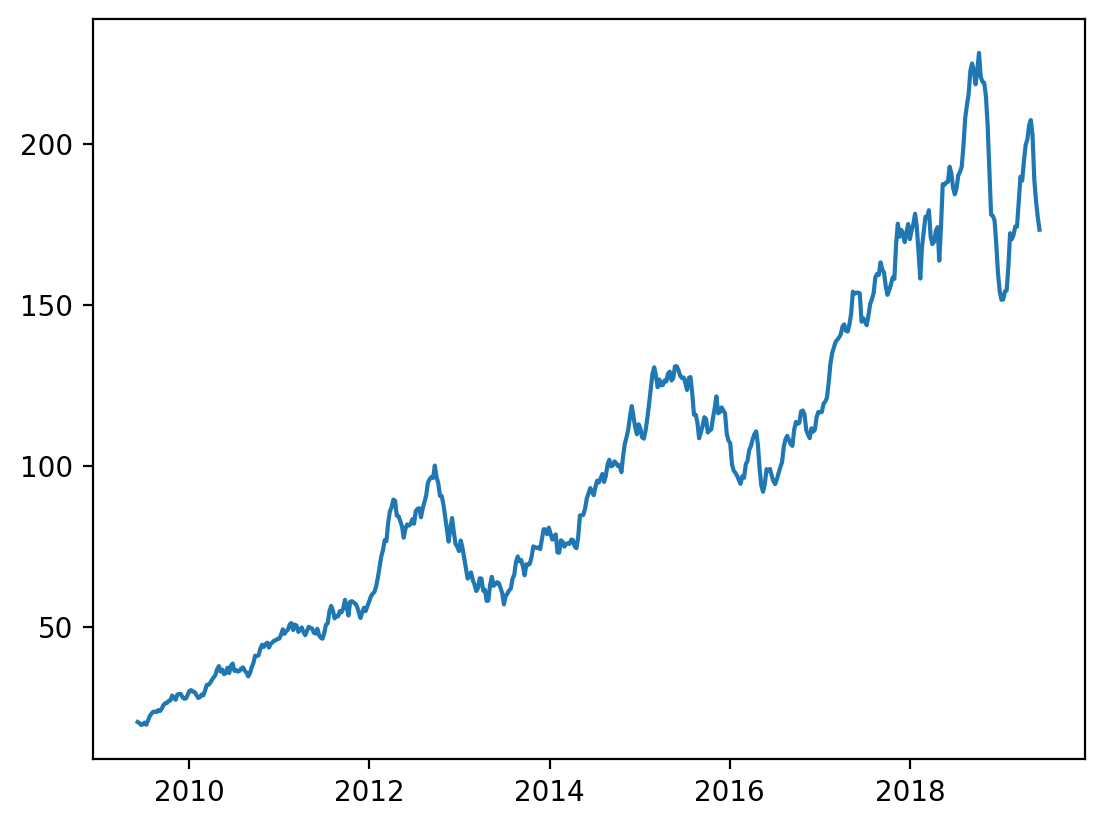

In [10]:
plt.plot(df_week)

In [11]:
# As we see in the above plot, the time series is not stationary so we will take calculate
# log returns and check whether they are stationary

In [12]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,-0.016712
2009-06-21,19.525140,-0.029358
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396


,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


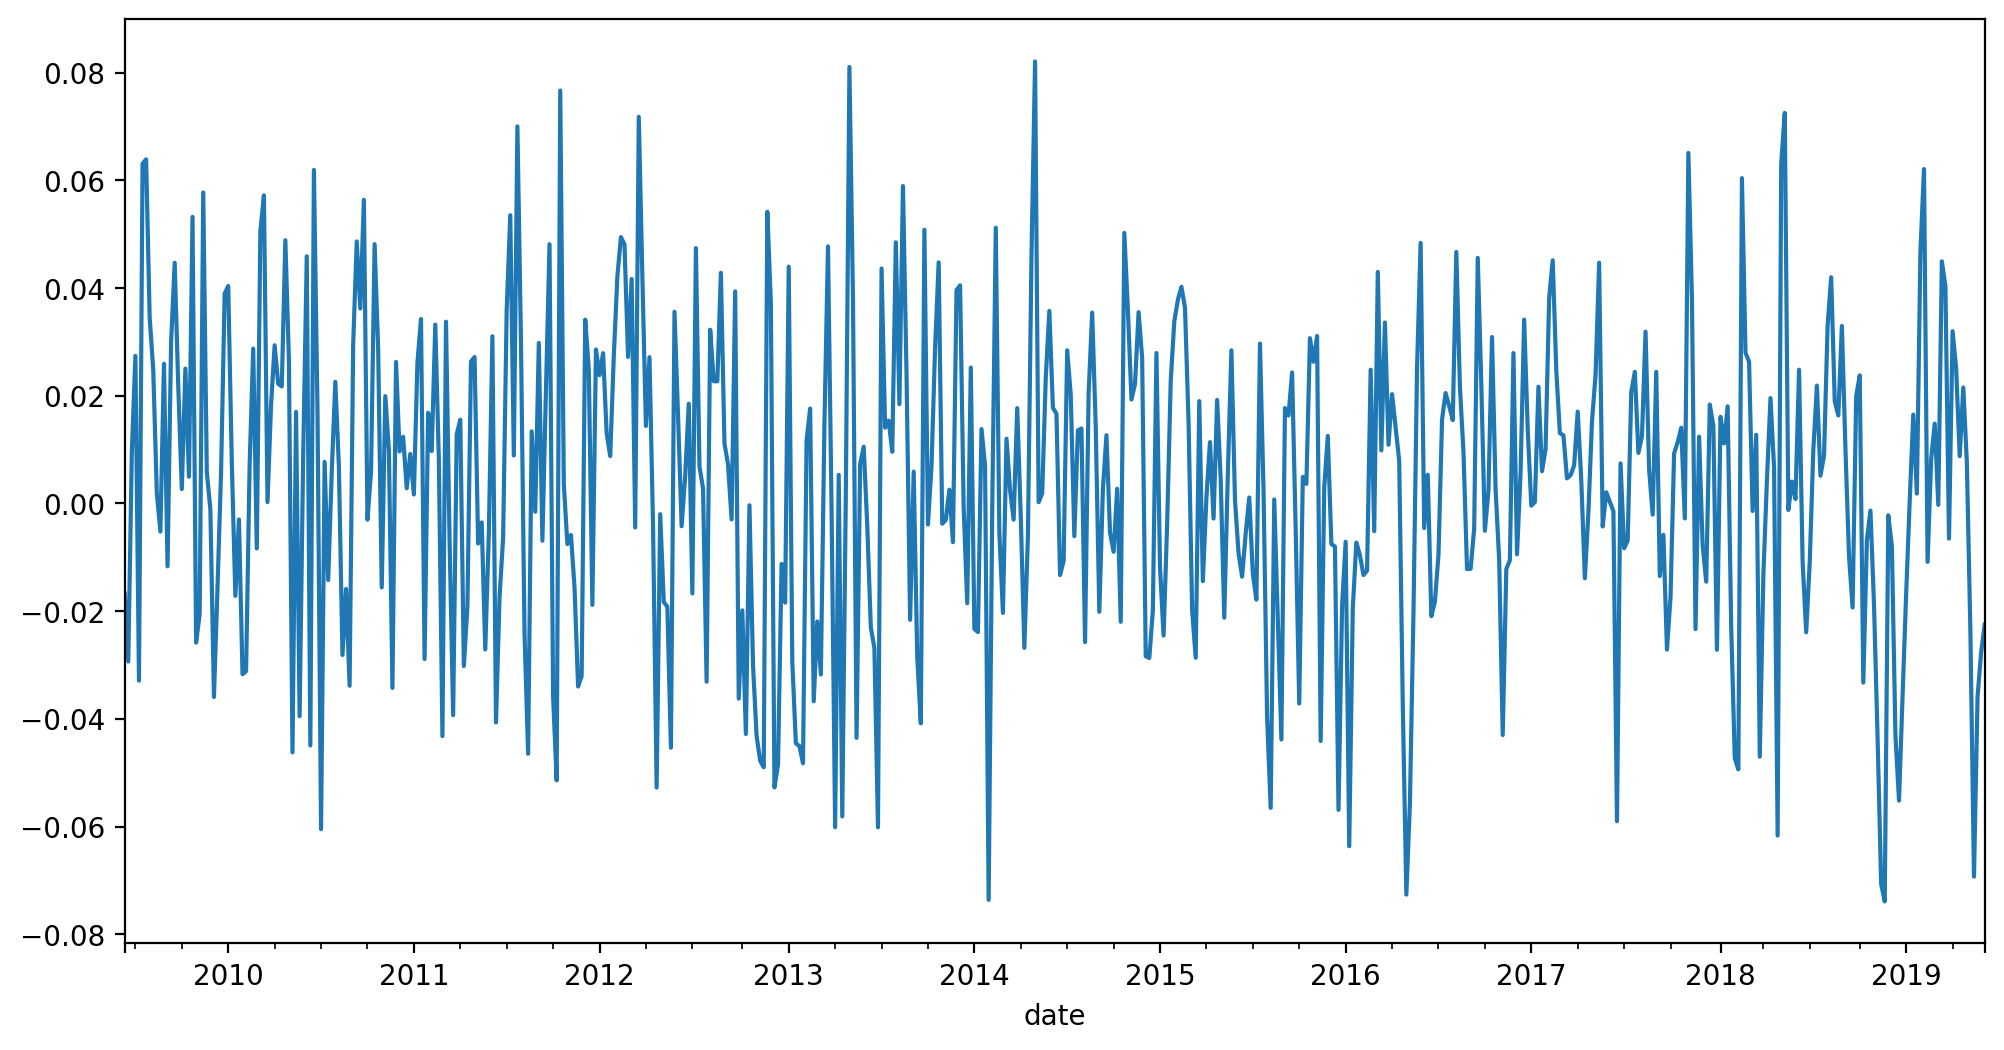

In [13]:
# drop null rows
df_week.dropna(inplace=True)
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

# getting a new data frame with log returns only
udiff = df_week.drop(['close'], axis=1)
udiff.head()

In [14]:
# As we can see in the graph by visual inspection, the time series looks stationary let us use a more
# formal approach to check for stationarity


Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity.

In [15]:
# importing necessary libraries for the test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [16]:
# Computing 20 weeks (window size 20) rolling mean and standard deviation
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

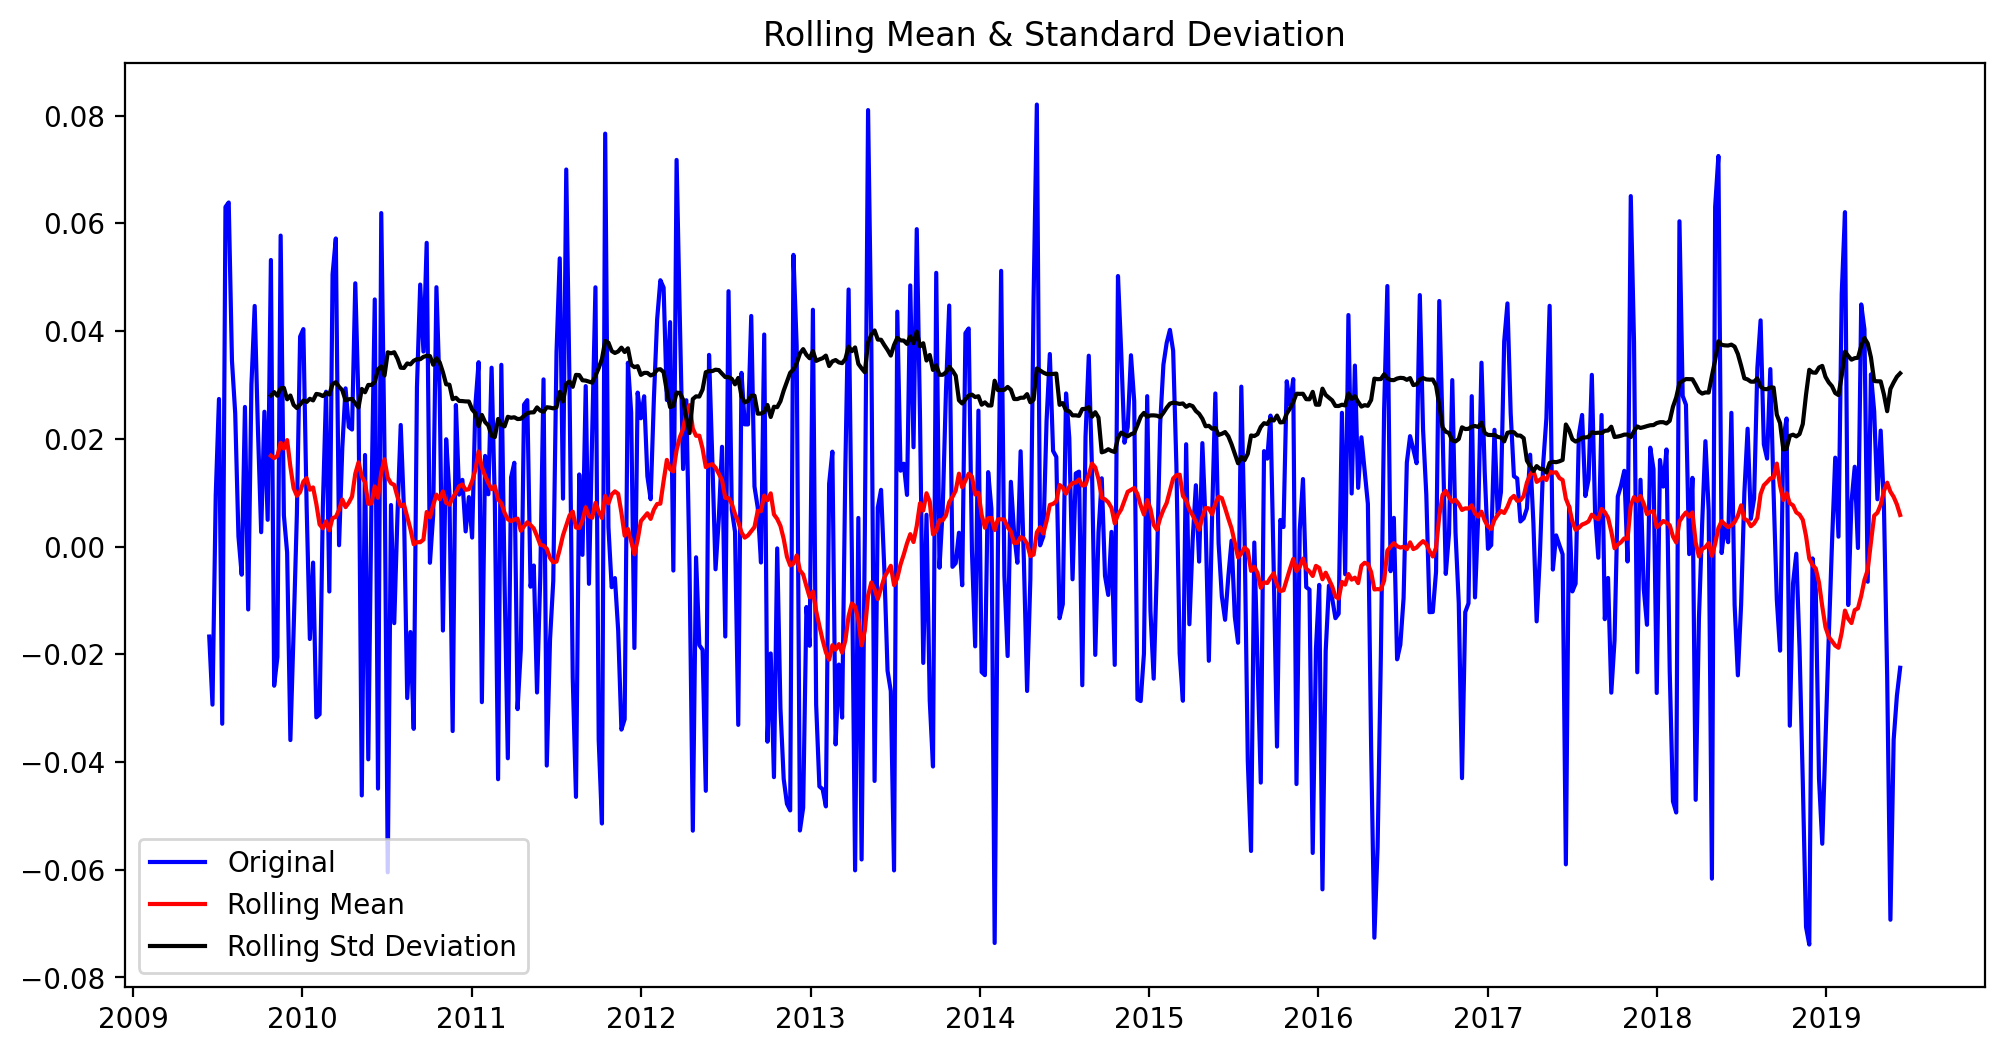

In [17]:
# Ploting the data
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)


In [18]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value

dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

In [19]:
# As the p-value we get is very low < 0.05 (significance level of 95%),
# we can reject the null hypothesis in dickey fuller test (H0: The time series is not stationary).
# Hence the time series is stationary, so that we can now use ARIMA model wit the differencing parameter as 0 ie ARIMA(p, d, q) = ARIMA(p, 0, q)



**ACF and PACF Charts**:

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them.


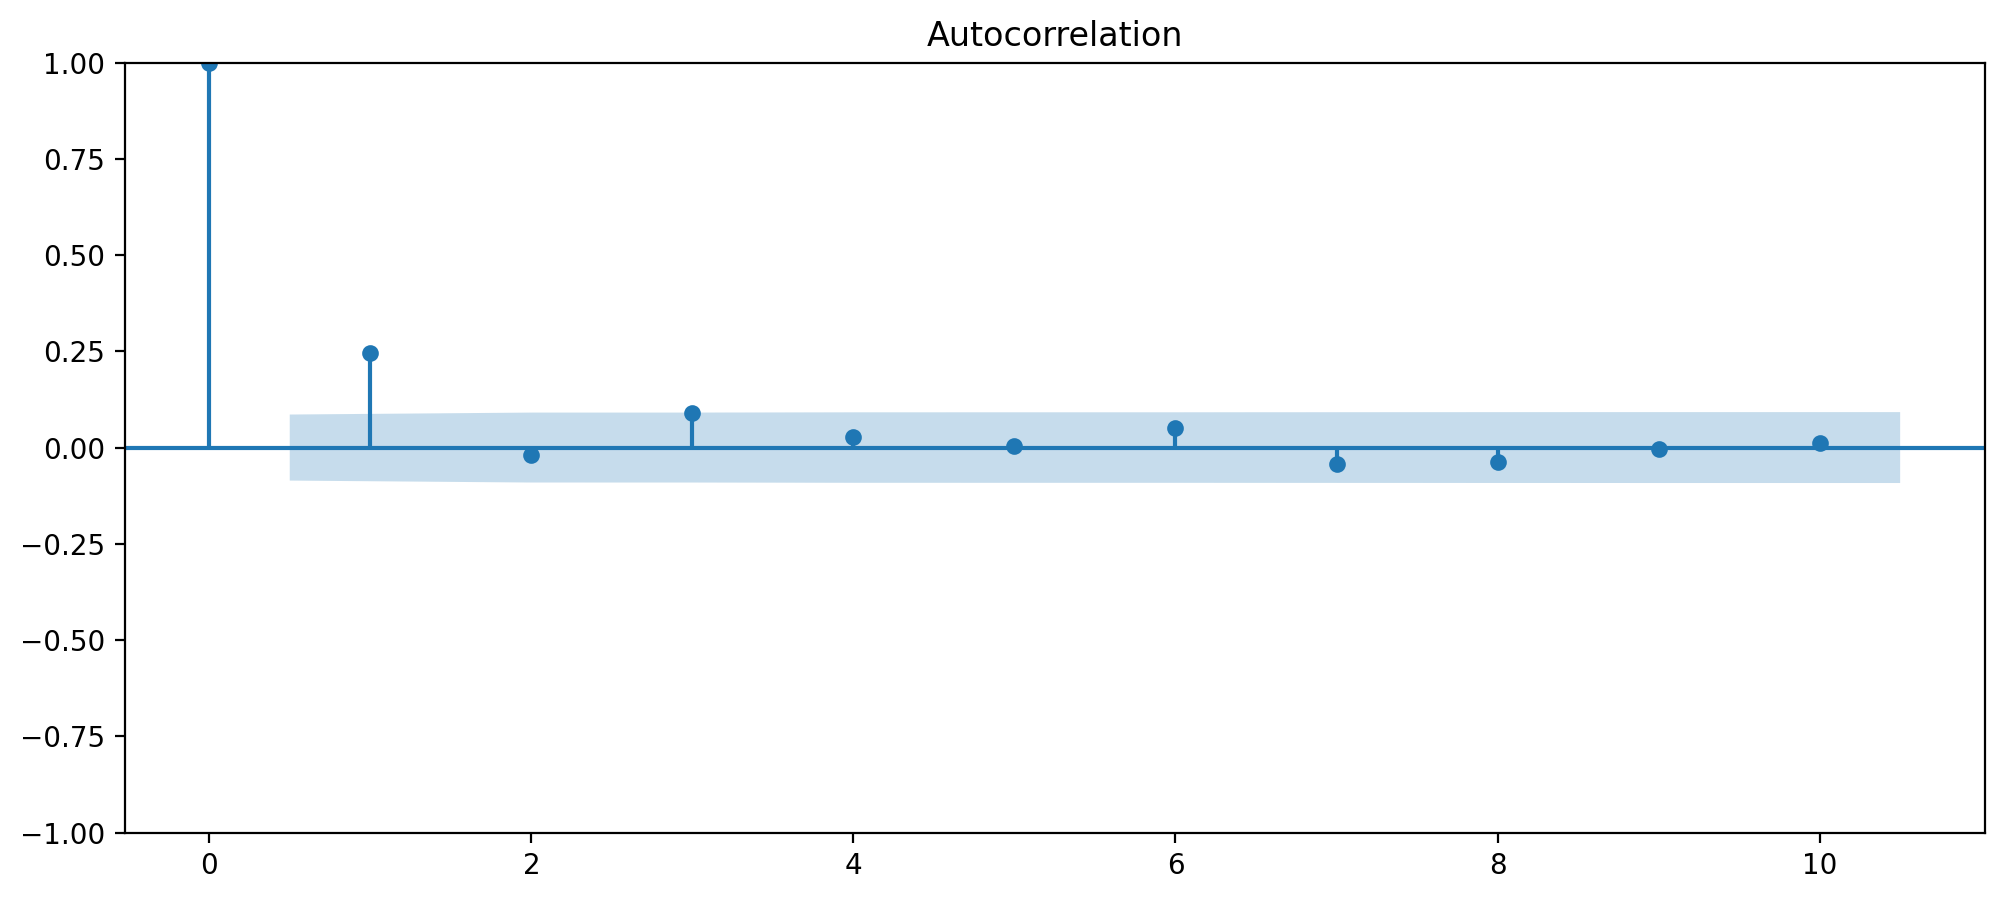

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))

#plotting acf chart
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

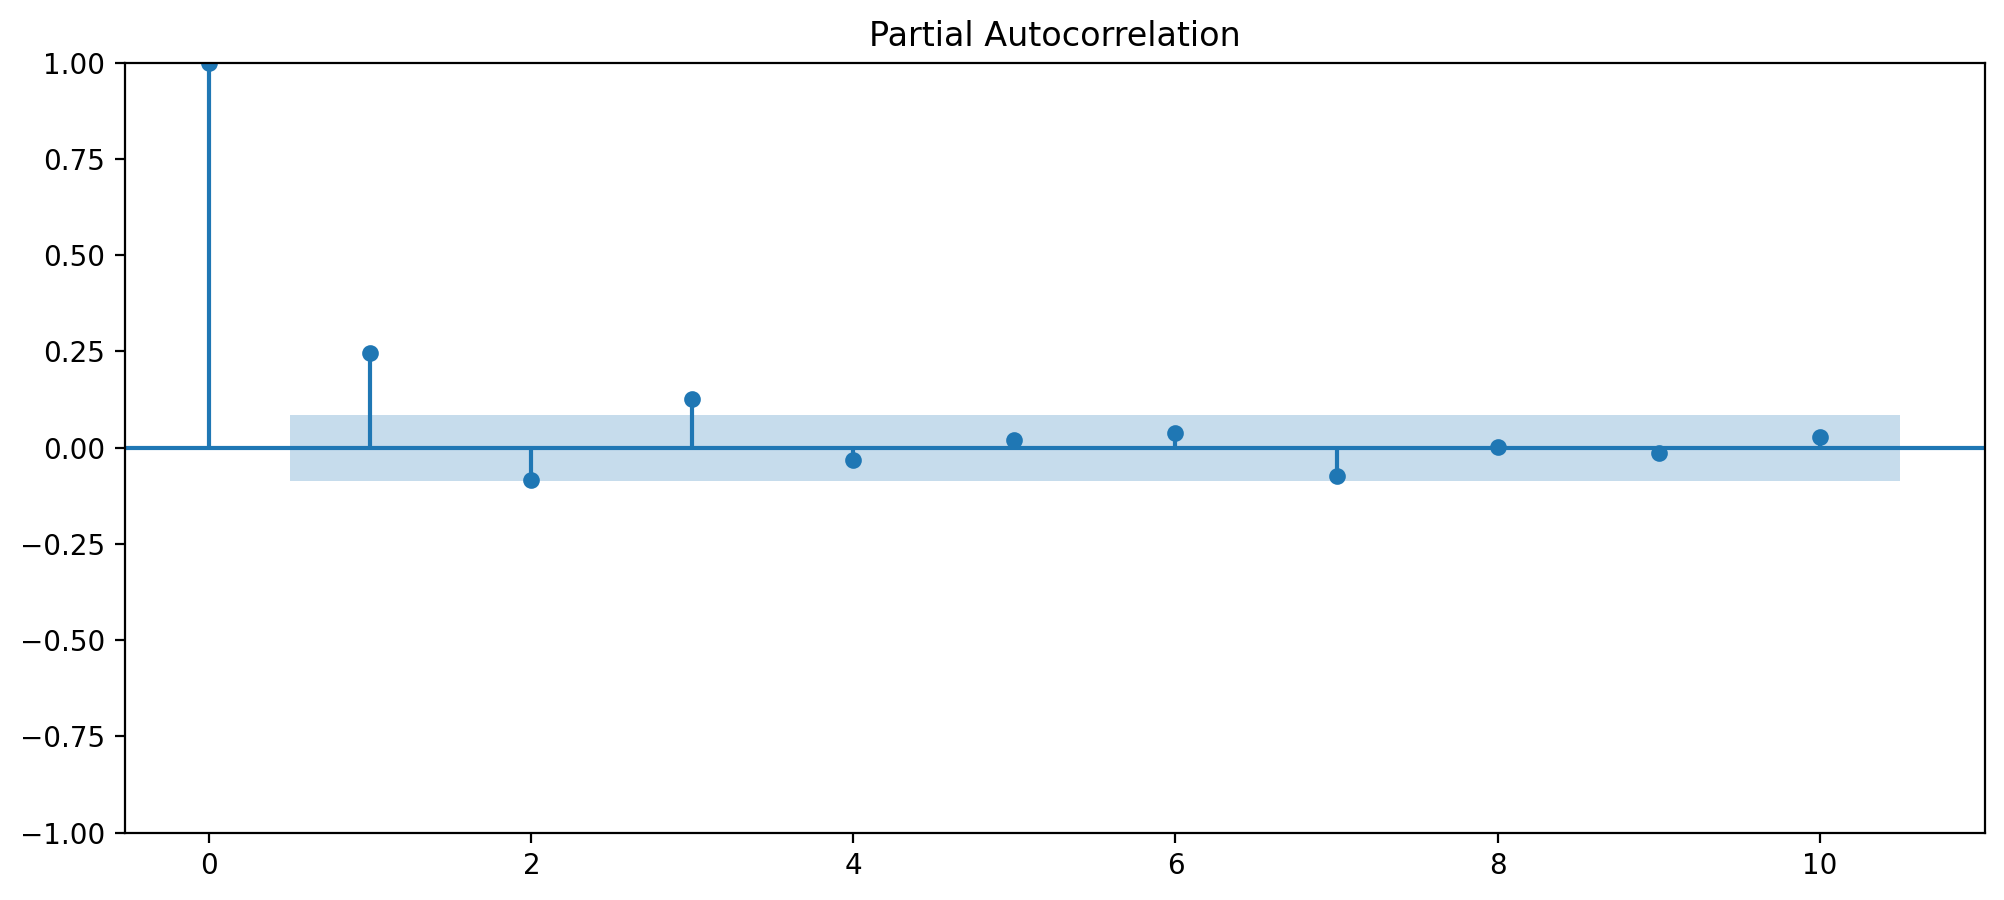

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(12,5))


# plotting pacf chart
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

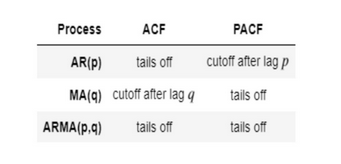

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1.

Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC(Akaike’s Information Criterion) - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model hyperparameters


**Build ARIMA Model**

Since we differenced the weekly closing prices, we technically only need to build an ARMA model as The data has already been integrated (I in ARIMA) using differencing and is stationary.


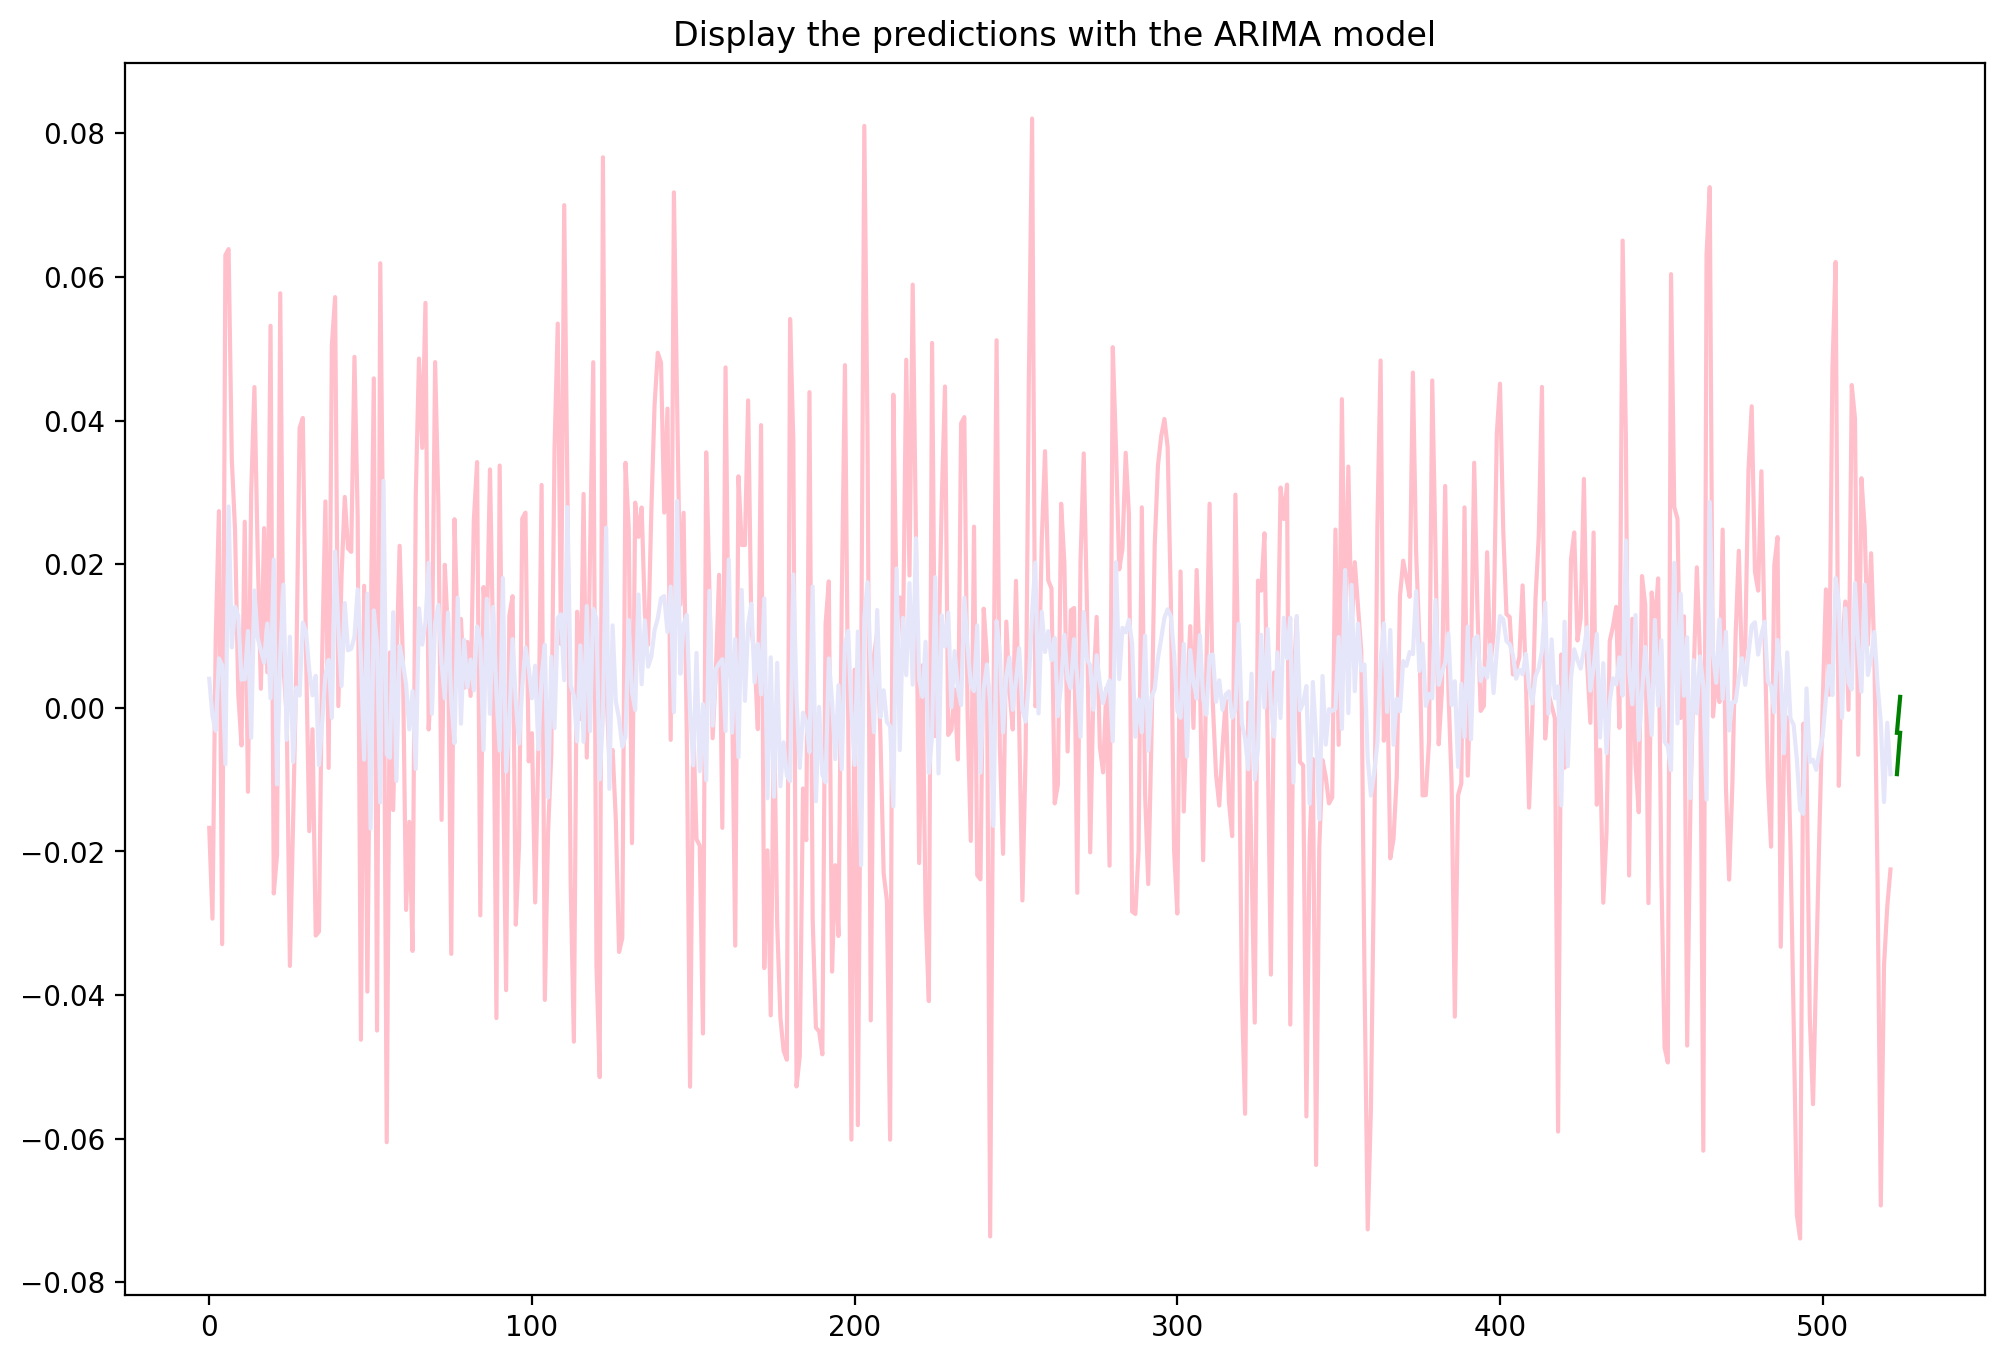

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Notice that we have to use udiff - the differenced data rather than the original data.
# Also as we have already integrated our data, we will pass value of d as 0
# Value of p = 3, q = 1 ARIMA(p, d, q) = ARIMA(3, 0, 1)

model = ARIMA(udiff.values, order = (3, 0, 1)).fit()

# Let's make a forecast 2 weeks ahead:
# number of weeks to forecast data for
steps = 2

# using our trained model for forecasting
forecast = model.forecast(steps=steps)

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='pink')

# models prediction for the period where we have the actual data values
preds = model.fittedvalues
plt.plot(preds, color='lavender')

# Plotting the predictions at the end of the time series
plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

**Section 3: Analysis** (10 points)

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                 ARIMA(3, 0, 1)   Log Likelihood                1131.553
Date:                Sat, 04 Nov 2023   AIC                          -2251.105
Time:                        00:01:58   BIC                          -2225.559
Sample:                             0   HQIC                         -2241.100
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.345      0.019       0.001       0.007
ar.L1          0.1259      0.337      0.373      0.709      -0.536       0.787
ar.L2         -0.0770      0.101     -0.765      0.444      -0.274       0.120
ar.L3          0.1140      0.058      1.958      0.050      -0.000       0.228
ma.L1          0.1562      0.340      0.459      0.646      -0.510       0.822
sigma2         0.0008   4.79e-05     15.993      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.98   Prob(JB):                         1.00
Heteroskedasticity (H):               0.75   Skew:                            -0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see, the p-values for our lags- lag1-0.709, lag2-0.444, and lag3-0.05 are all greater than or equal to 0.05 threshold, so we cannot reject the null hypothesis of Ljung-Box test and hence these lags are not statistically significant. Which implies our model doesn't work well for the given hyperparameters and data. (though estimated constant is statistically significant)

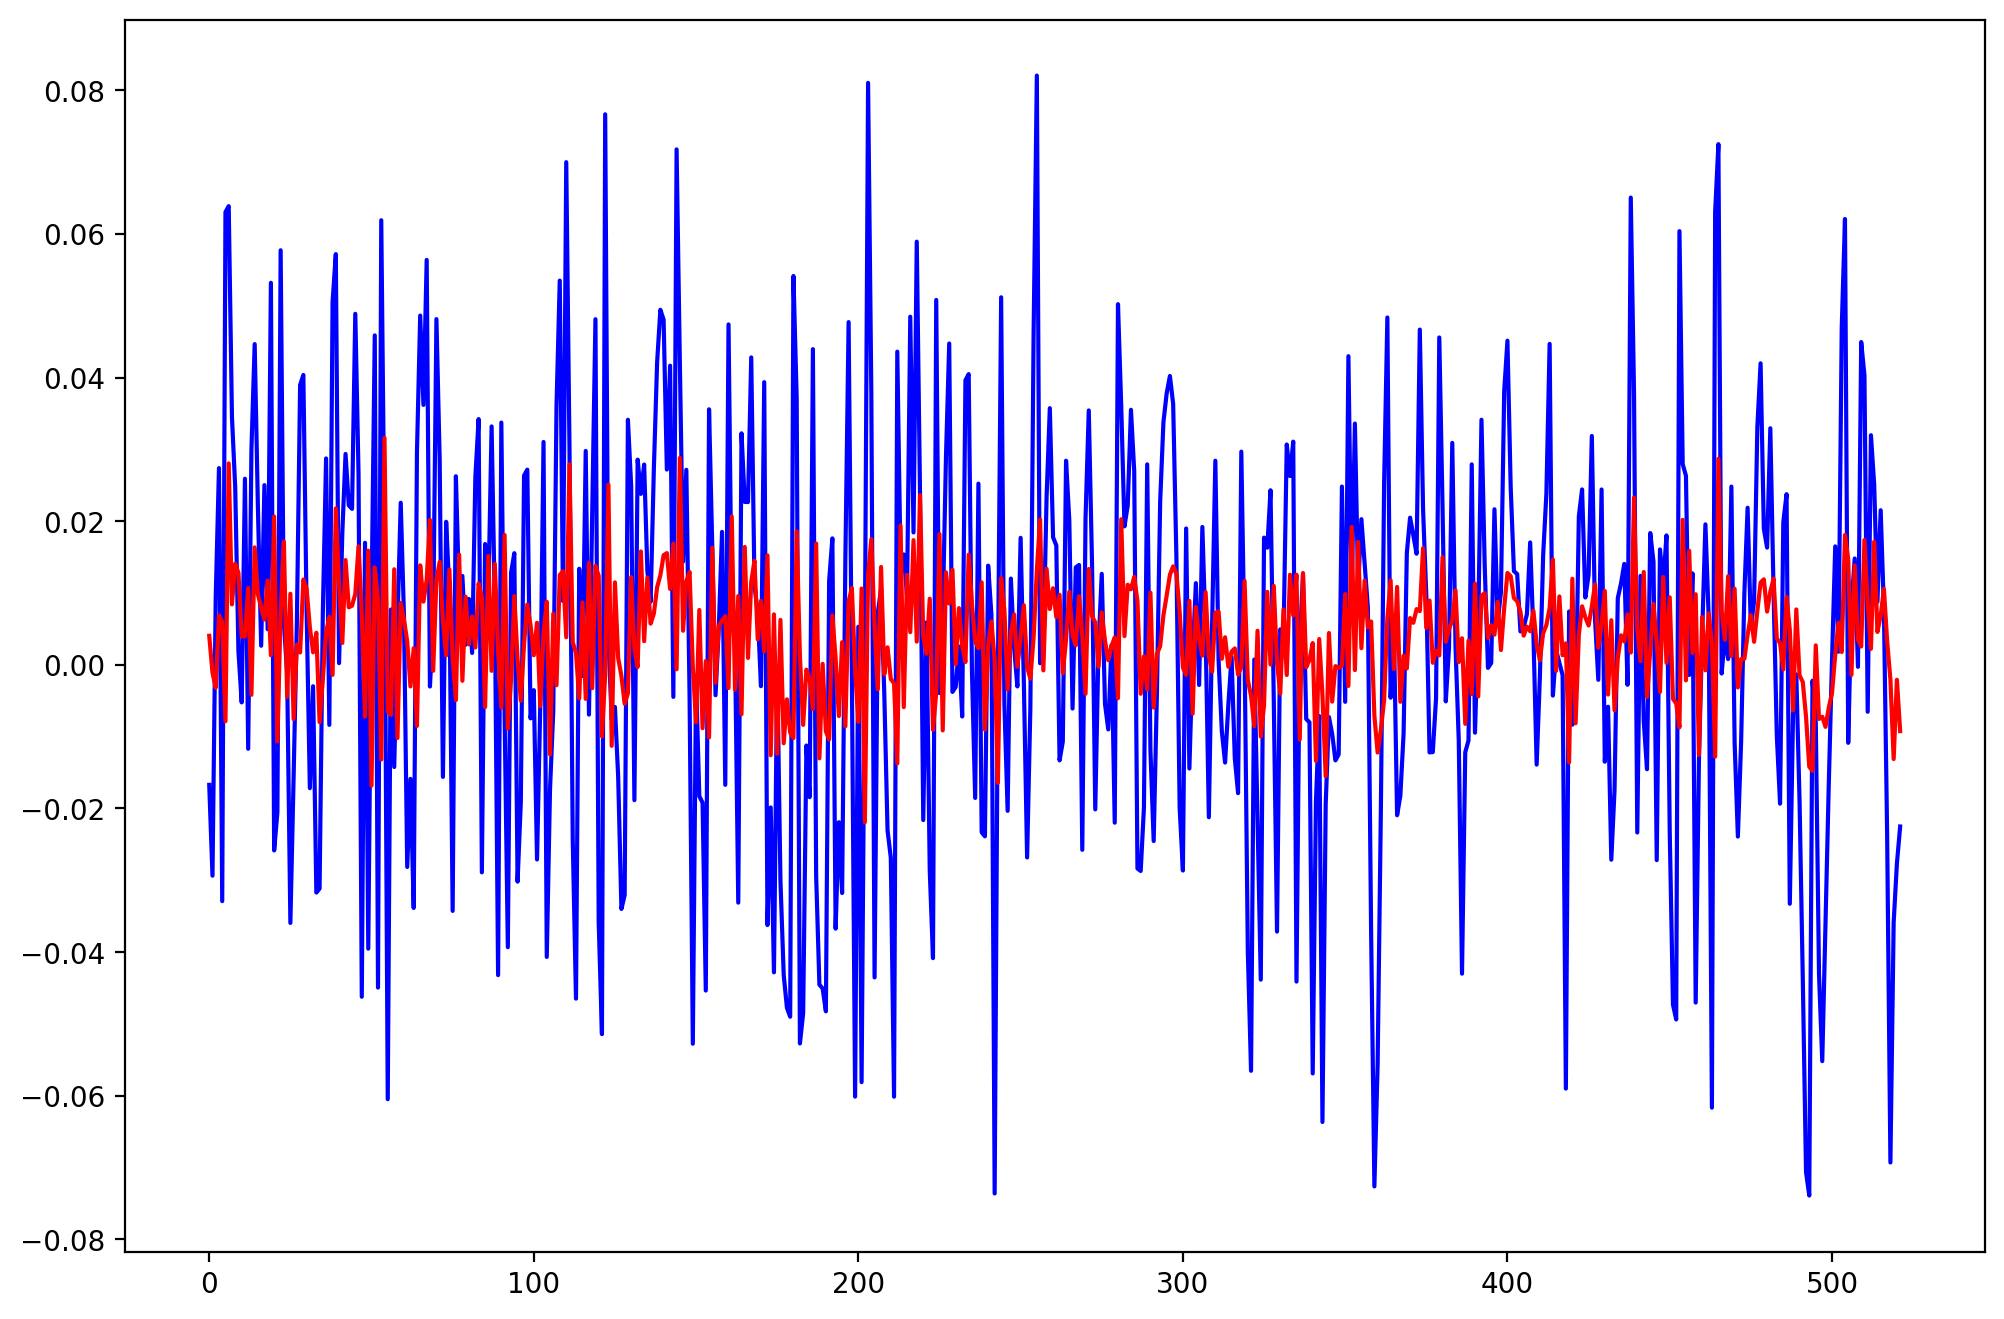

In [24]:

plt.figure(figsize=(12, 8))

# Values in the data in blue
plt.plot(udiff.values, color='blue')

preds = model.fittedvalues
#prediction of values in red
plt.plot(preds, color='red')
plt.show()

# Our model doesn't do a good job predicting variance in the original data (peaks and valleys).


**Discussion:** Delve into the pros and cons of the model, commenting on potential
overfitting, or other relevant observations

As we can see the red values are much smaller than the actual blue values and hence our model does not perform well and it underfits the data(not able to model the variance of the data accurately). By varying the hyperparameters we can try to improve our model with new values for ARIMA hyperparameters p, d and q. Our model may still not perform well as our underlying assumptions about linearity may not be true.

**Pros of the models:**

1.  Simple and easy to implement and interpret
2.  ARIMA model can model non stationary time series
3.  More flexible than simple linear regression
4.  Can account for a variety of patterns such as trends, volatility and fluctuations

**Cons of the models:**
1.  Assumes linearity
2.  Not performing well for our data
3.  Only good for short forecasts
4.  No definite method to choose correct hyperparameters p, d and q, need to rely on subjective judgement
5. Cannot be used for seasonal time series


**2) PCA**

**Section 1**: Introduction (5 points)

**Problem Statement:** Using principal component analysis to reduce the dimensionality of dataset for credit card fraud detection. This reduced dataset will be used for fraud detection in the next problem.

**Data Description:**: We will use kaggle's fraud detection dataset(standardized)- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/ and we will reduce its dimensionality from 30 attributes to 10 attributes. The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

We are referreing to https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html for the code

**Section 2**: **Implementation - Code and Notes**

In [25]:
# importing pandas and PCA (from sklearn)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [26]:
# reading the data in a dataframe
df = pd.read_csv('creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
# dropping the time from the dataset as I believe time is not a relevant feature
X = df.drop(['Time', 'Class'], axis = 1)
X.dropna()
# saving the actual class values seperately
Y = pd.DataFrame(df['Class'])
X.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [28]:
# We will have 10 principal components
pca = PCA(n_components=10)

In [29]:
# Applying the PCA dimensionality reduction to the data
X = pca.fit_transform(X)

**Section 3: Analysis** (10 points)

In [30]:
# Getting eigenvalues/singualr values in decreasing order corresponding to each principal component
print(pca.singular_values_)

[133484.08223699   1032.81347659    832.9700465     792.45006938
    754.55739535    718.21653339    688.56610819    638.51677789
    587.4656091     583.61176132]


In [31]:

vars = pca.explained_variance_ratio_.copy()
for i in range(len(vars)):
  vars[i] *= 100

In [32]:
# printing percenatge variance explained by each principal component
print(vars)

[9.99538016e+01 5.98389755e-03 3.89223565e-03 3.52276905e-03
 3.19392649e-03 2.89368434e-03 2.65969381e-03 2.28709910e-03
 1.93599955e-03 1.91068207e-03]


In [33]:
# As we can see 99% of the variance in the data can be explained by only one of the principal component
# This is happening as the data is highly unbalanced
# Theoritically we can only keep the first principal component as it crosses the threshold of 99% variability by itself
# but we will keep other components too as they might be usefull for fitting highly unbalanced data.

**Discussion:** Delve into the pros and cons of the model, commenting on potential
overfitting, or other relevant observations

Reducing from 30 features to 10 feaures does not decrease the information content in our data significantly. We will use this reduced data now to predict fraud using SVM classifier

**Pros of the models:**

1.  Removes correlated features to avoid redudancy
2.  As it reduces data size it improves algorithm performance
3.  PCA reduces pverfitting
4.  improves visualization if reduced dimension size is 2

**Cons of the models:**
1.  As principal component are linear combination of original features, they are less interpretable
2.  Data Standardization must before PCA
3.  Some information loss is bound to happen
4.  number of principal components is a hyperparameter and requires careful choosing


**3) SVM**

**Section 1**: Introduction (5 points)

**Problem Statement**: Using Support vector machine classifier for credit card fraud detection (Classification with 2 classes - fraud(1) and Non fraud(0)

**Data Description**:: We will use kaggle's fraud detection dataset(standardized)- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/ and we will reduce its dimensionality from 30 attributes to 10 attributes. The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

We are referring to https://www.kaggle.com/code/vvineeth/credit-card-fraud-detection-with-svm/notebook for the code

**Section 2**: **Implementation - Code and Notes**

In [34]:
# The data we will use to train our svm model from the previous problem's solution
df = pd.DataFrame(X)

In [35]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,61.271382,1.319273,-1.294377,-2.374183,1.135230,-0.264861,0.103159,-0.158353,0.396352,0.047362
1,-85.661826,-1.043593,0.113306,-0.247835,0.439843,0.048910,-0.001741,-0.055344,-0.319456,0.051464
2,290.316696,0.810956,-1.363911,-1.744699,0.089902,-1.339892,0.432706,-0.450481,-1.169602,-0.939792
3,35.151659,0.928399,-1.107035,-1.399739,-0.974910,-1.182478,0.258813,-0.418771,-1.256882,-0.521703
4,-18.360281,1.316996,-0.141292,-1.775990,0.186037,-0.060644,-0.387020,0.129975,1.118094,-0.397134


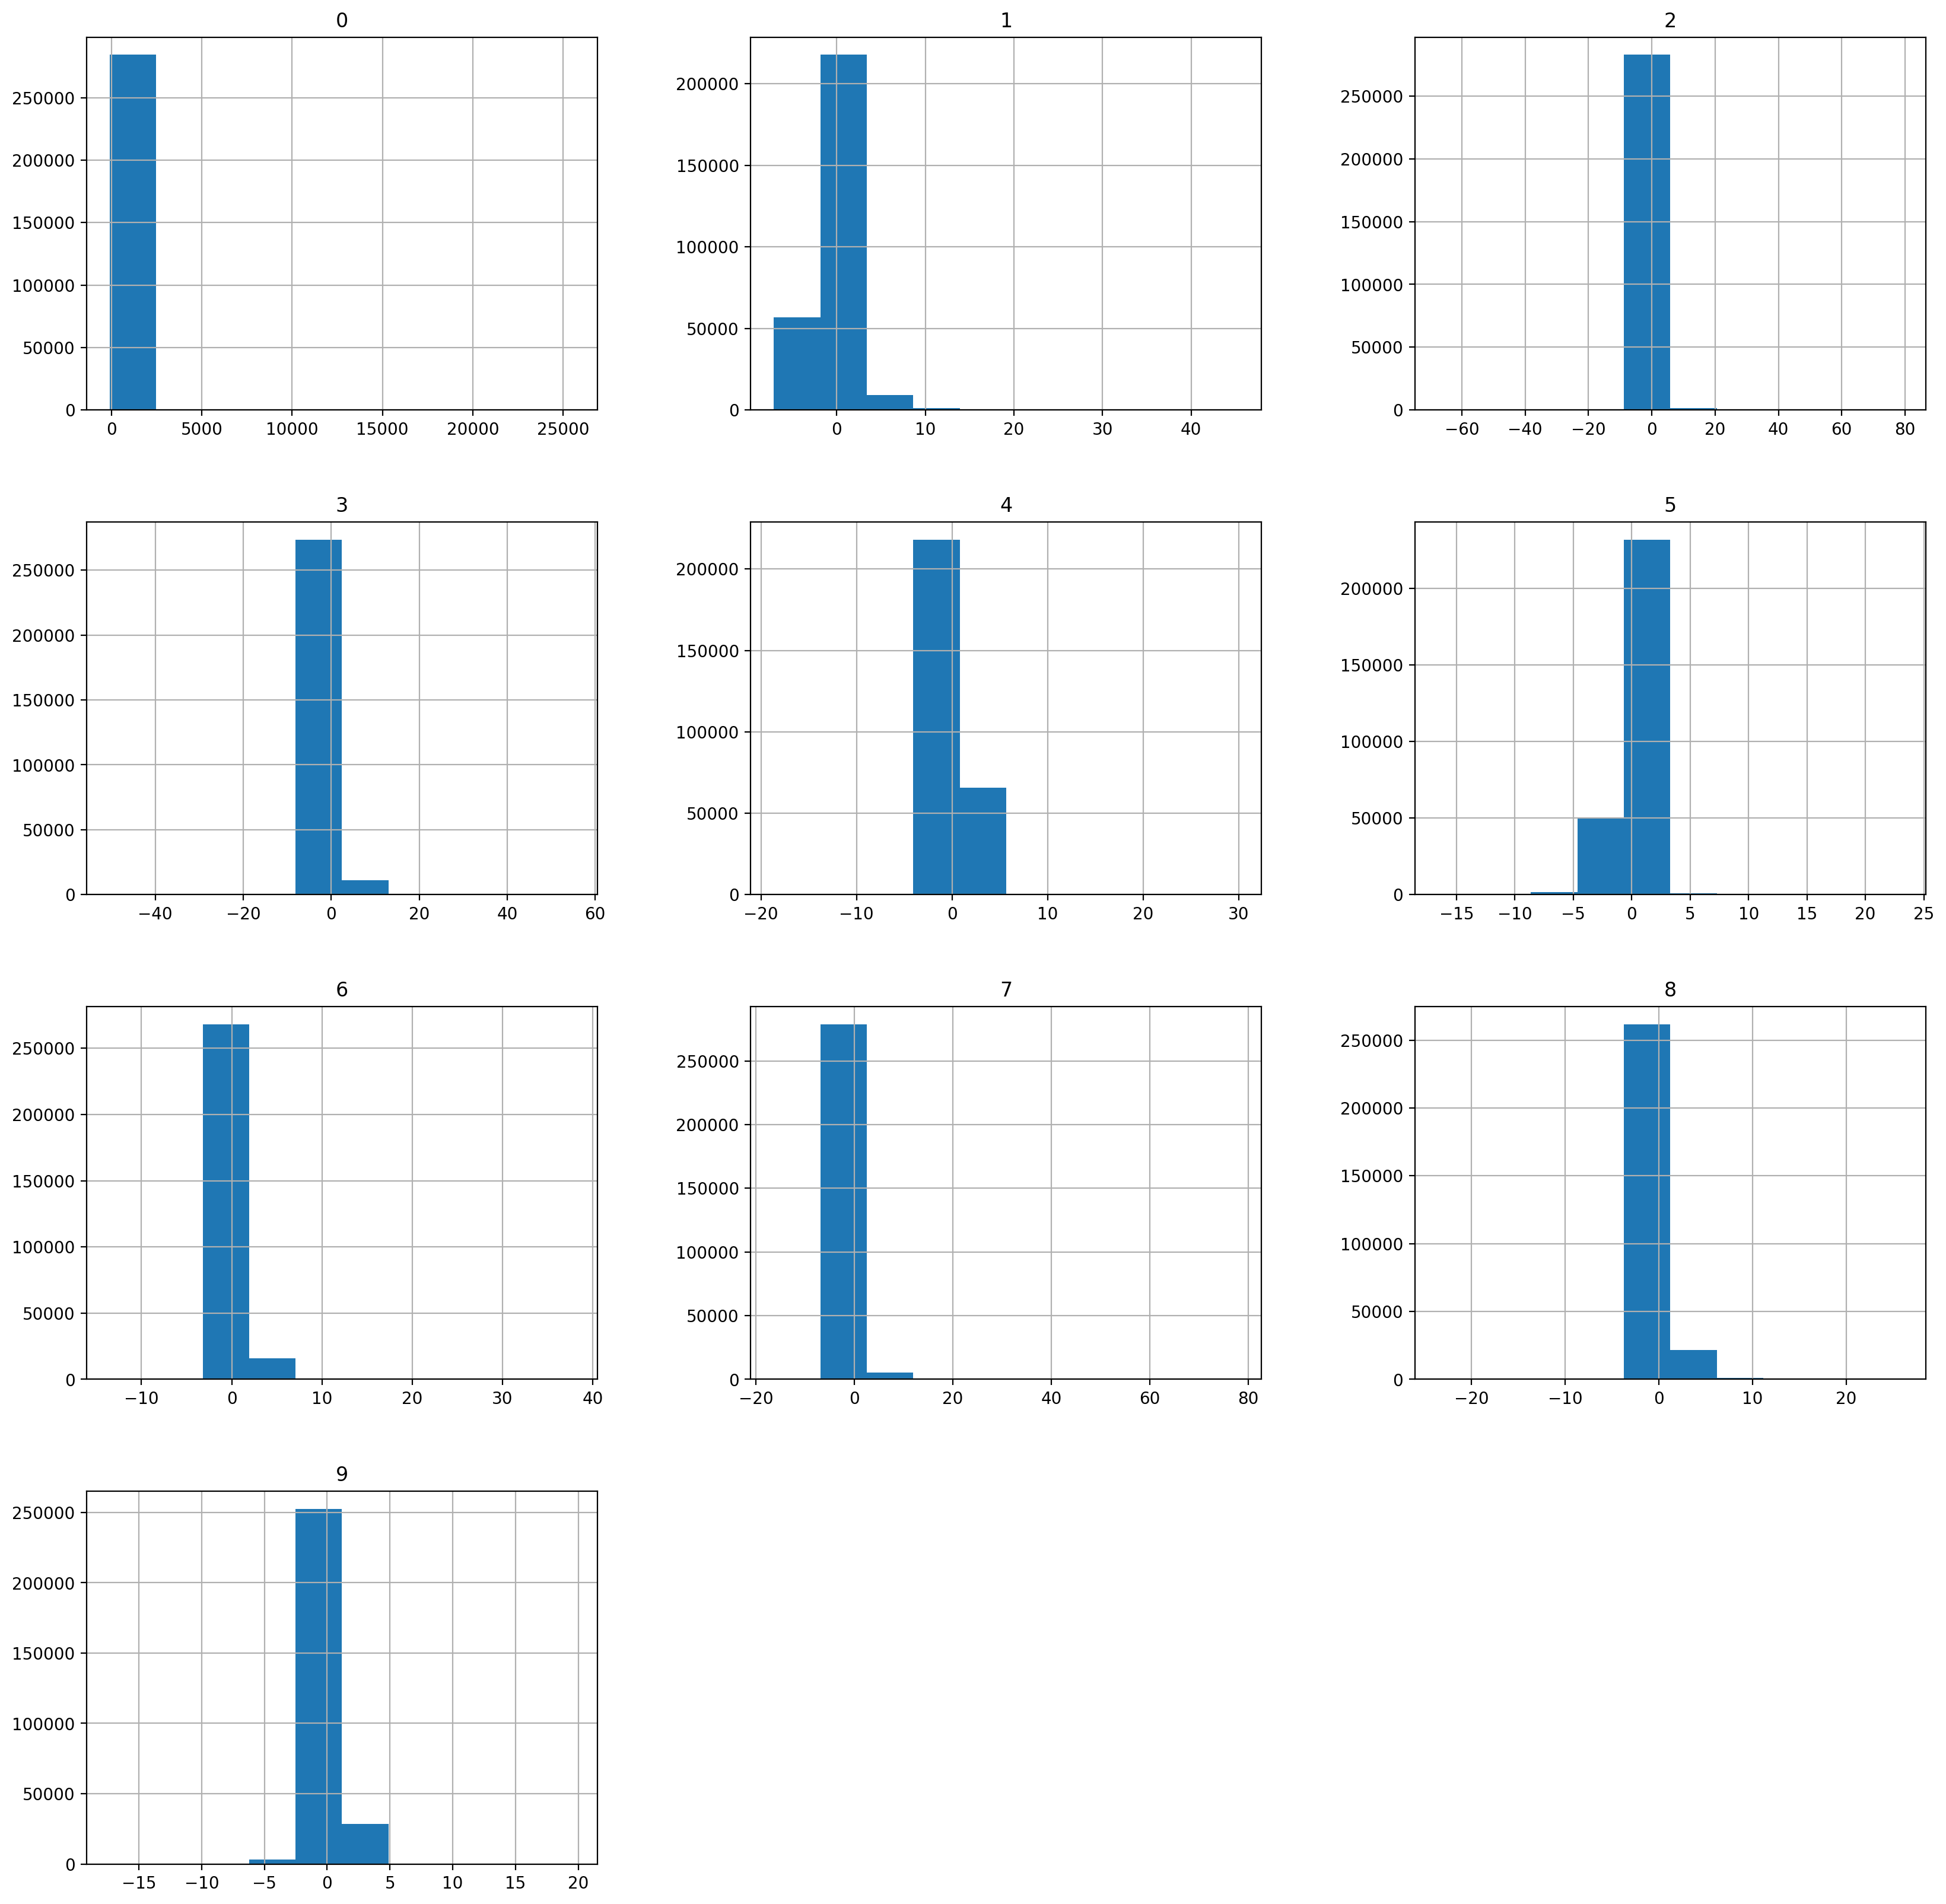

In [36]:
# Visualizing the input attributes
df.hist(figsize=(20,20))
plt.show()



We can see most of the attributes are clustered around 0 with some or no outliers. Notice we have very few fraudulent cases over valid cases in our class histogram.


In [37]:
# This is our class labels: 0 for non fraud cases and 1 for frauds
Y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [38]:
# determine the number of fraud cases
fraud = Y[Y['Class'] == 1]
valid = Y[Y['Class'] == 0]

outlier_frac = len(fraud)/float(len(valid))
print("outliar frac: ", outlier_frac)

print("Number of fraud transactions: ", len(fraud))
print("Number of valid transactions: ", len(valid))

# Our data set is highly unbalanced, we have very few fraud examples

outliar frac:  0.0017304750013189597
Number of fraud transactions:  492
Number of valid transactions:  284315


In [39]:
# We will first try 2 non linear kernels rbf and sigmoid and compare their performance

In [40]:
# importing necessary libraries

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

y = Y['Class']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=100)
# Svm with non linear kernel-rbf
model1 = SVC(kernel = 'rbf')

model1.fit(train_X, train_y)

prediction1 = model1.predict(test_X)

In [41]:
# Svm with non linear kernel-sigmoid
model2 = SVC(kernel = 'sigmoid')
model2.fit(train_X, train_y)

prediction2 = model2.predict(test_X)

**Section 3: Analysis** (10 points)

In [42]:
# Analyzing the first model
print(confusion_matrix(test_y, prediction1))
print('\n')
print(accuracy_score(test_y, prediction1))
# The values in the confusion matrix may change slightly on new runs
# As we can see in the confusion matrix the model1 only classifies 4 (this may change) true fraud case as fraud,
# it classifies other 200 true fraud cases as non fraud and due to unbalanced nature of data still gets the high accuracy score

[[113719      0]
 [   204      0]]


0.9982093168192551


In [43]:
print(confusion_matrix(test_y, prediction2))
print('\n')
print(accuracy_score(test_y, prediction2))
# The values in the confusion matrix may change slightly on new runs
# As we can see in the confusion matrix the model2 classifies 15 true fraud case as fraud,
# it classifies other 189 true fraud cases as non fraud and due to unbalanced nature of data still gets the high accuracy score
# as we can from the confusion matrix there is significant improvement over previous model

[[113718      1]
 [   189     15]]


0.9983322068414631


In [44]:
# It seems that sigmoid kernel works bettter than the rbf kernel but
# As accuracy scores do not tell us much about the performance of the model in case of highly unbalanced data,
# we will use F1 Score (2*precision*recall/(Precision + recall)) as an evaluation metric for the comparison

In [45]:
from sklearn.metrics import f1_score

In [46]:
# F1 score for svm with rbf kernel
f1_score(test_y, prediction1)

0.0

In [47]:
# F1 score for svm with sigmoid kernel
f1_score(test_y, prediction2)

0.13636363636363638

In [48]:
# As f1 score ranges from 0 to 1, and if it is close to 1, the model is better.
# Both models in our case (with rbf kernel) perform very poorly in terms of f1 score for fraud detection problem
# But svm with sigmoid kernel has f1 score which is 15 times the f1 score in the case of sigmoid kernel
# Which means svm with sigmoid kernel performs much better than svm with rbf kernel
# we should choose some alternative model for the classification

**Discussion:** Delve into the pros and cons of the model, commenting on potential
overfitting, or other relevant observations

We have to select a model for classification which is designed to handle highly unbalanced data to improve our results

**Pros of the models:**

1.  SVM is particularly good for binary classification
2.  SVM are memory efficient
3.  SVM are more effective in high dimensional space where there are a large number of attributes
4.  SVM are less prone to overfitting than other algorithms like neural networks
5. SVM has means to prevent the model from being sensitive to outliers in the data

**Cons of the models:**
1.  SVM is not suitable for large datasets and its training complexity is highly dependent on the size of the datasets
2.  SVM does not perform well in the presence of significant noise in the dataset
3.  SVM will underperform when the number of features for each data point exceeds the number of training data samples
4.  SVM sacrifices the distribution of data, which can lead to lower accuracy and stability when dealing with big and complex sentiment data
5. The choice of kernel can greatly affect the performance of an SVM and it can be difficult to determine best kernel for a given dataset.

**4) SVR**

**Section 1**: Introduction (5 points)

**Problem Statement**: Predicting the stock price of a company(Apple) using Support Vector Regression model.

**Data Description:** : We use the following data: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/ai-for-finance/data/AAPL10Y.csv for the analysis and prediction. This is AAPL company's 10 years share price (in usd) data from 2009 to 2019.

We are referring for the code to: https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

**Section 2**: **Implementation - Code and Notes**

In [49]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVR
df = pd.read_csv('AAPL10Y.csv')

# Converting the dates in standard format
df['date'] = pd.to_datetime(df['date'])

# Sorting the dataframe on dates and using dates as an index to make the data represent a time series
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()


(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


In [50]:
# Resampling the data from daily values to weekly average
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


In [51]:
df_week.dropna(inplace=True)

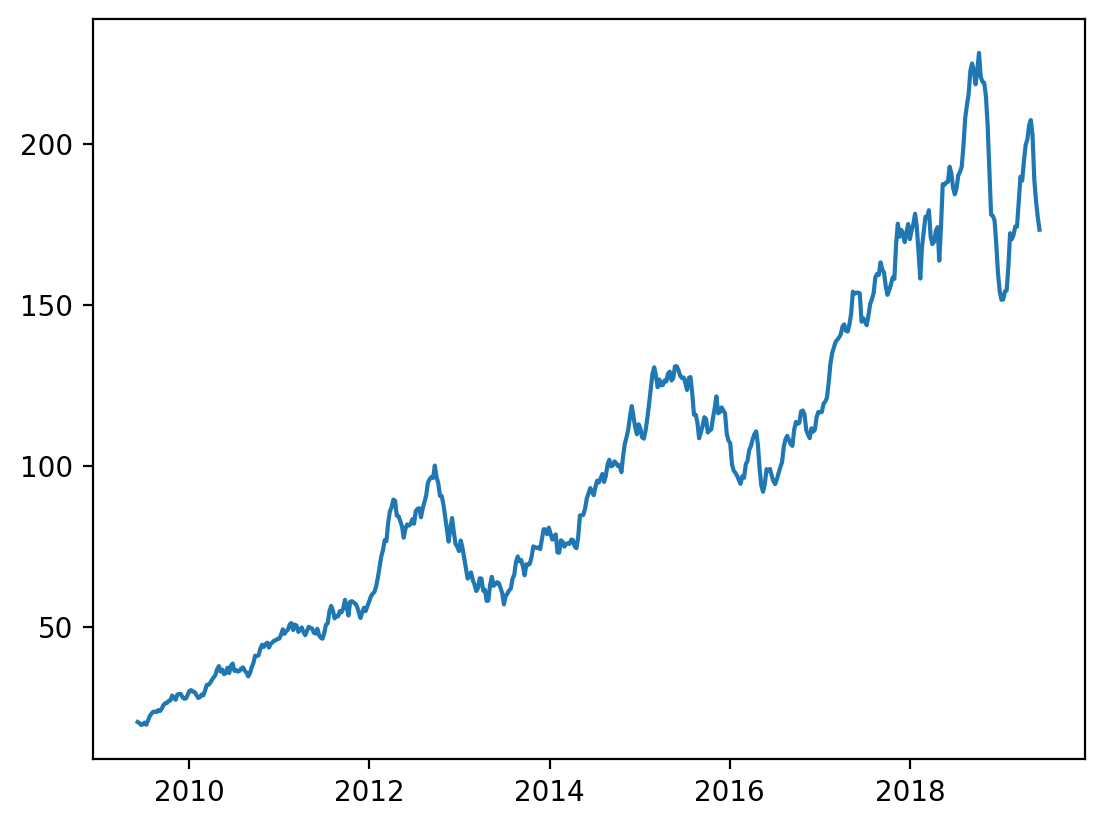

In [52]:
plt.plot(df_week)

Allocate a 8 year period from January 1 2010 to January 1, 2018 to the training set. The test set will include the two-month period of January 2 2018 to March 2 2018

In [53]:
train_start_dt = '2010-01-01 00:00:00'
test_start_dt = '2018-01-01 00:00:00'

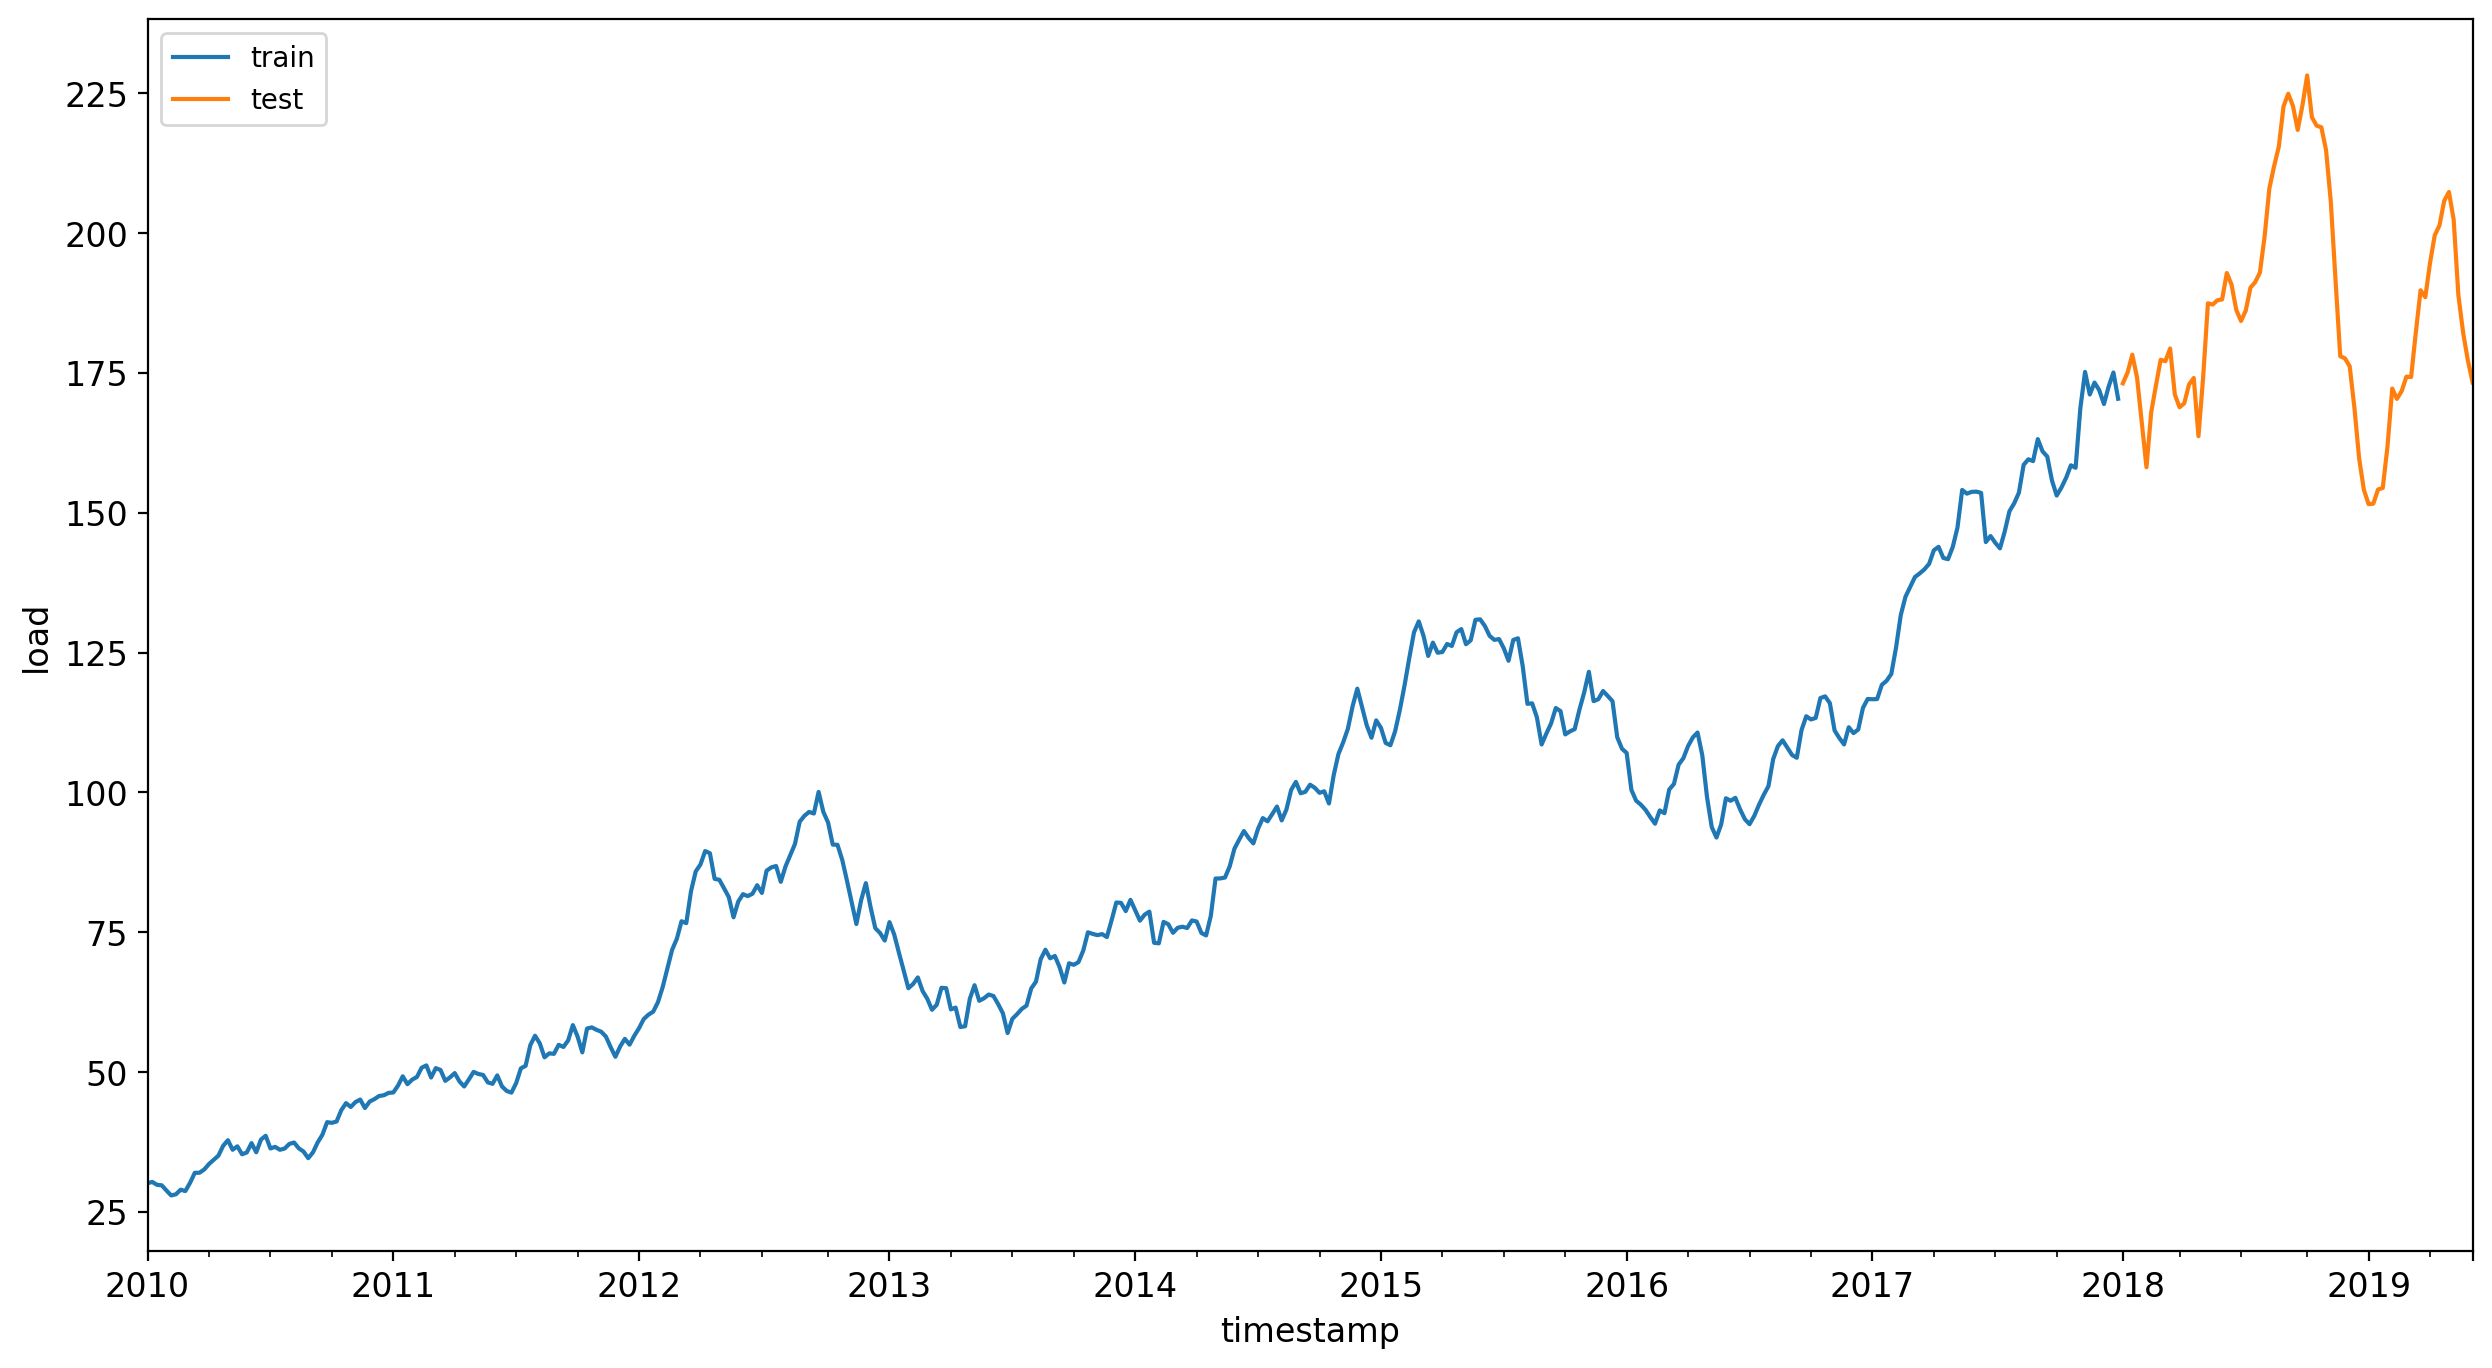

In [54]:
# Visualizing the training and testing period
df_week[(df_week.index < test_start_dt) & (df_week.index >= train_start_dt)][['close']].rename(columns={'close':'train'}) \
    .join(df_week[test_start_dt:][['close']].rename(columns={'close':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [55]:
# Let us prepare the data for training and tetsing
train = df_week.copy()[(df_week.index >= train_start_dt) & (df_week.index < test_start_dt)][['close']]
test = df_week.copy()[df_week.index >= test_start_dt][['close']]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (418, 1)
Test data shape:  (75, 1)


In [56]:
# scale the training and tetsing data as SVR with rbf kernel needs scaling

scaler = MinMaxScaler()
train['close'] = scaler.fit_transform(train)
test['close'] = scaler.transform(test)

In [57]:
# For the SVR, you transform the input data to be of the form [batch, timesteps]. So, you reshape the existing train_data and test_data such that there is a new dimension which refers to the timesteps
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [58]:
#For this example, we take timesteps = 5. So, the inputs to the model are the data for the first 4 timesteps, and the output will be the data for the 5th timestep
timesteps=5

In [59]:
# Converting training data to 2D tensor using nested list comprehension:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(414, 5)

In [60]:
# similarly converting the testing data
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(71, 5)

In [61]:
# Selecting inputs and outputs from training and testing data:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(414, 4) (414, 1)
(71, 4) (71, 1)


In [62]:
# Now we will implement svr with hyperparamter values choosen by us
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)



In [63]:
model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [64]:
# make model predictions
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(414, 1) (71, 1)


**Section 3: Analysis** (10 points)

In [65]:
# Evaluate your model 1
# For evaluation, first we will scale back the data to our original scale. Then, to check the performance, we will plot the original and predicted time series plot.
# Scale the predicted and original output:

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

414 71


In [66]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

414 71


In [67]:
# Check model performance on training and testing data 1
# We extract the timestamps from the dataset to show in the x-axis of our plot. Note that we are using the first timesteps-1 values as out input for the first output, so the timestamps for the output will start after that.

train_timestamps = df_week[(df_week.index < test_start_dt) & (df_week.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df_week[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))


414 71


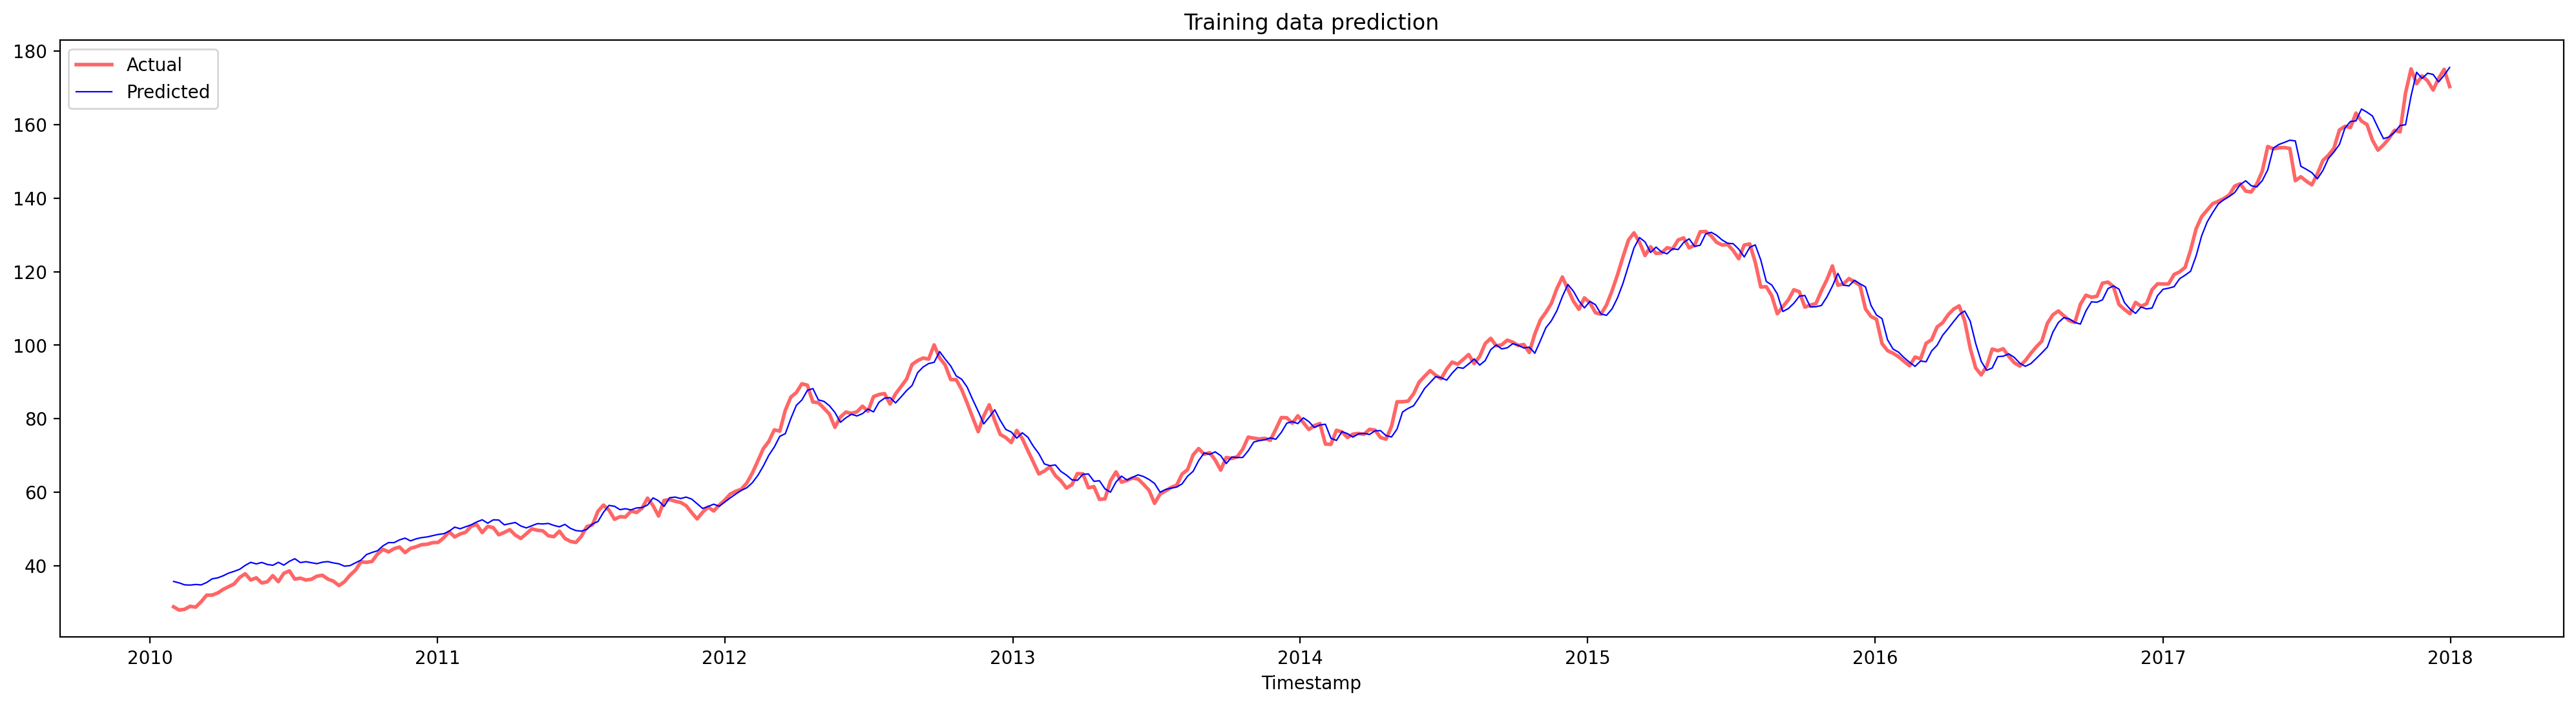

In [68]:
# Plot the predictions for training data:

plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

As we can see our model performs really well for the training dataset. Now we will check its performance for the entire dataset

In [69]:
# Extracting load values as numpy array
data = df_week.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (519, 5)
X shape:  (519, 4) 
Y shape:  (519, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [70]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

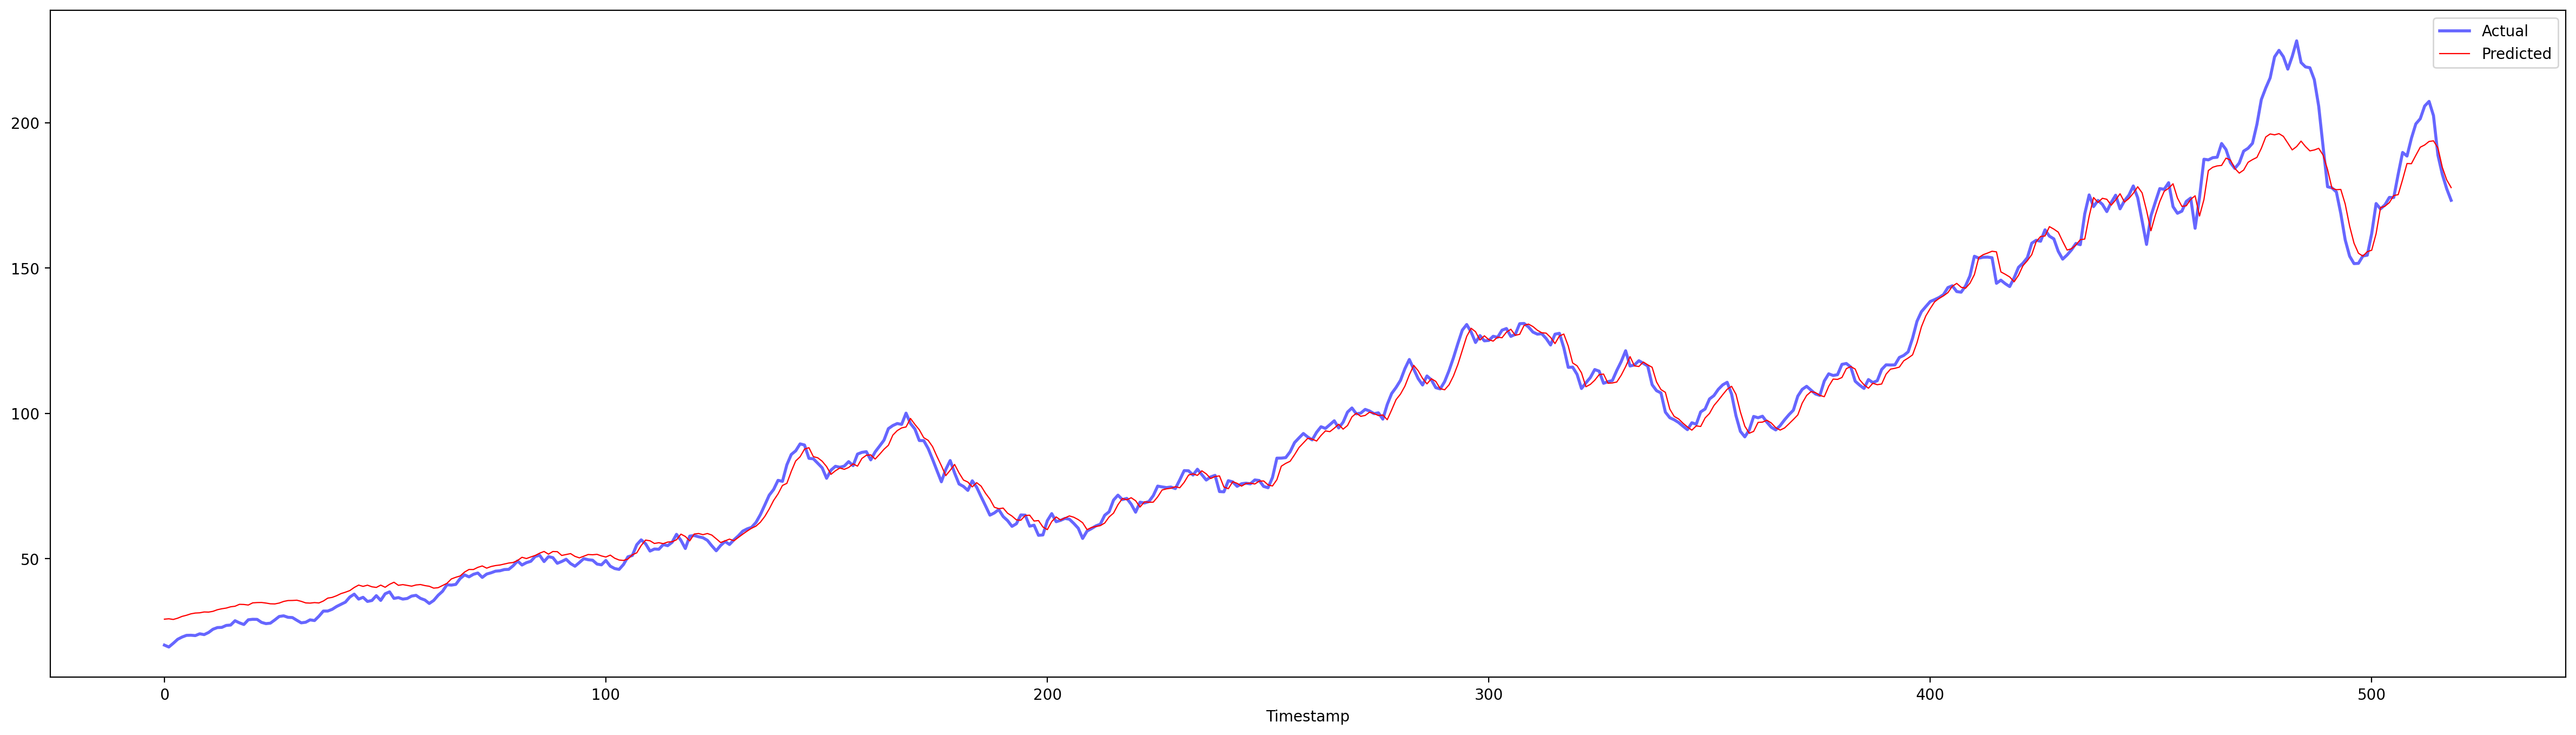

In [71]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

As we can see in the graph, our model performs well for training period but it does not perform well for the testing period.

**Discussion:** Delve into the pros and cons of the model, commenting on potential
overfitting, or other relevant observations

**Relevant Observations:** Overfitting and not having sufficient representative data are the 2 main reasons behind a model not generalizing well. In our case I think that during the tetsing period, there is a sudden jump in apple's stock prices and this can be due to a shock/particular significant event(like launch of a successful iphone) that happened at the start of 2018. SVR overfitted on the training data and was not able to model the shocks.

**Pros of the models:**

1.  SVR is robust to outliers
2.  Decision model can be easily updated
3.  SVR has easy implementation
4.  More often than not SVR generalizes really well (not in our case)

**Cons of the models:**
1.  SVR is not suitable for large datasets
2.  SVR will underperform when the number of features for each data point exceeds the number of training data samples
3. The decision model does not perform very well when the datasethas more noise
4. The choice of kernel can greatly affect the performance of an SVR and it can be difficult to determine best kernel for a given dataset.

In [72]:
# We used the same dataset for time series forecasting with ARIMA and now with SVR.
# As we can see from the figures, SVR was able to atleast give good performance on
# training set, whereas ARIMA failed to even perform on training set
# SVR was able to model the variance of the dataset much better than ARIMA



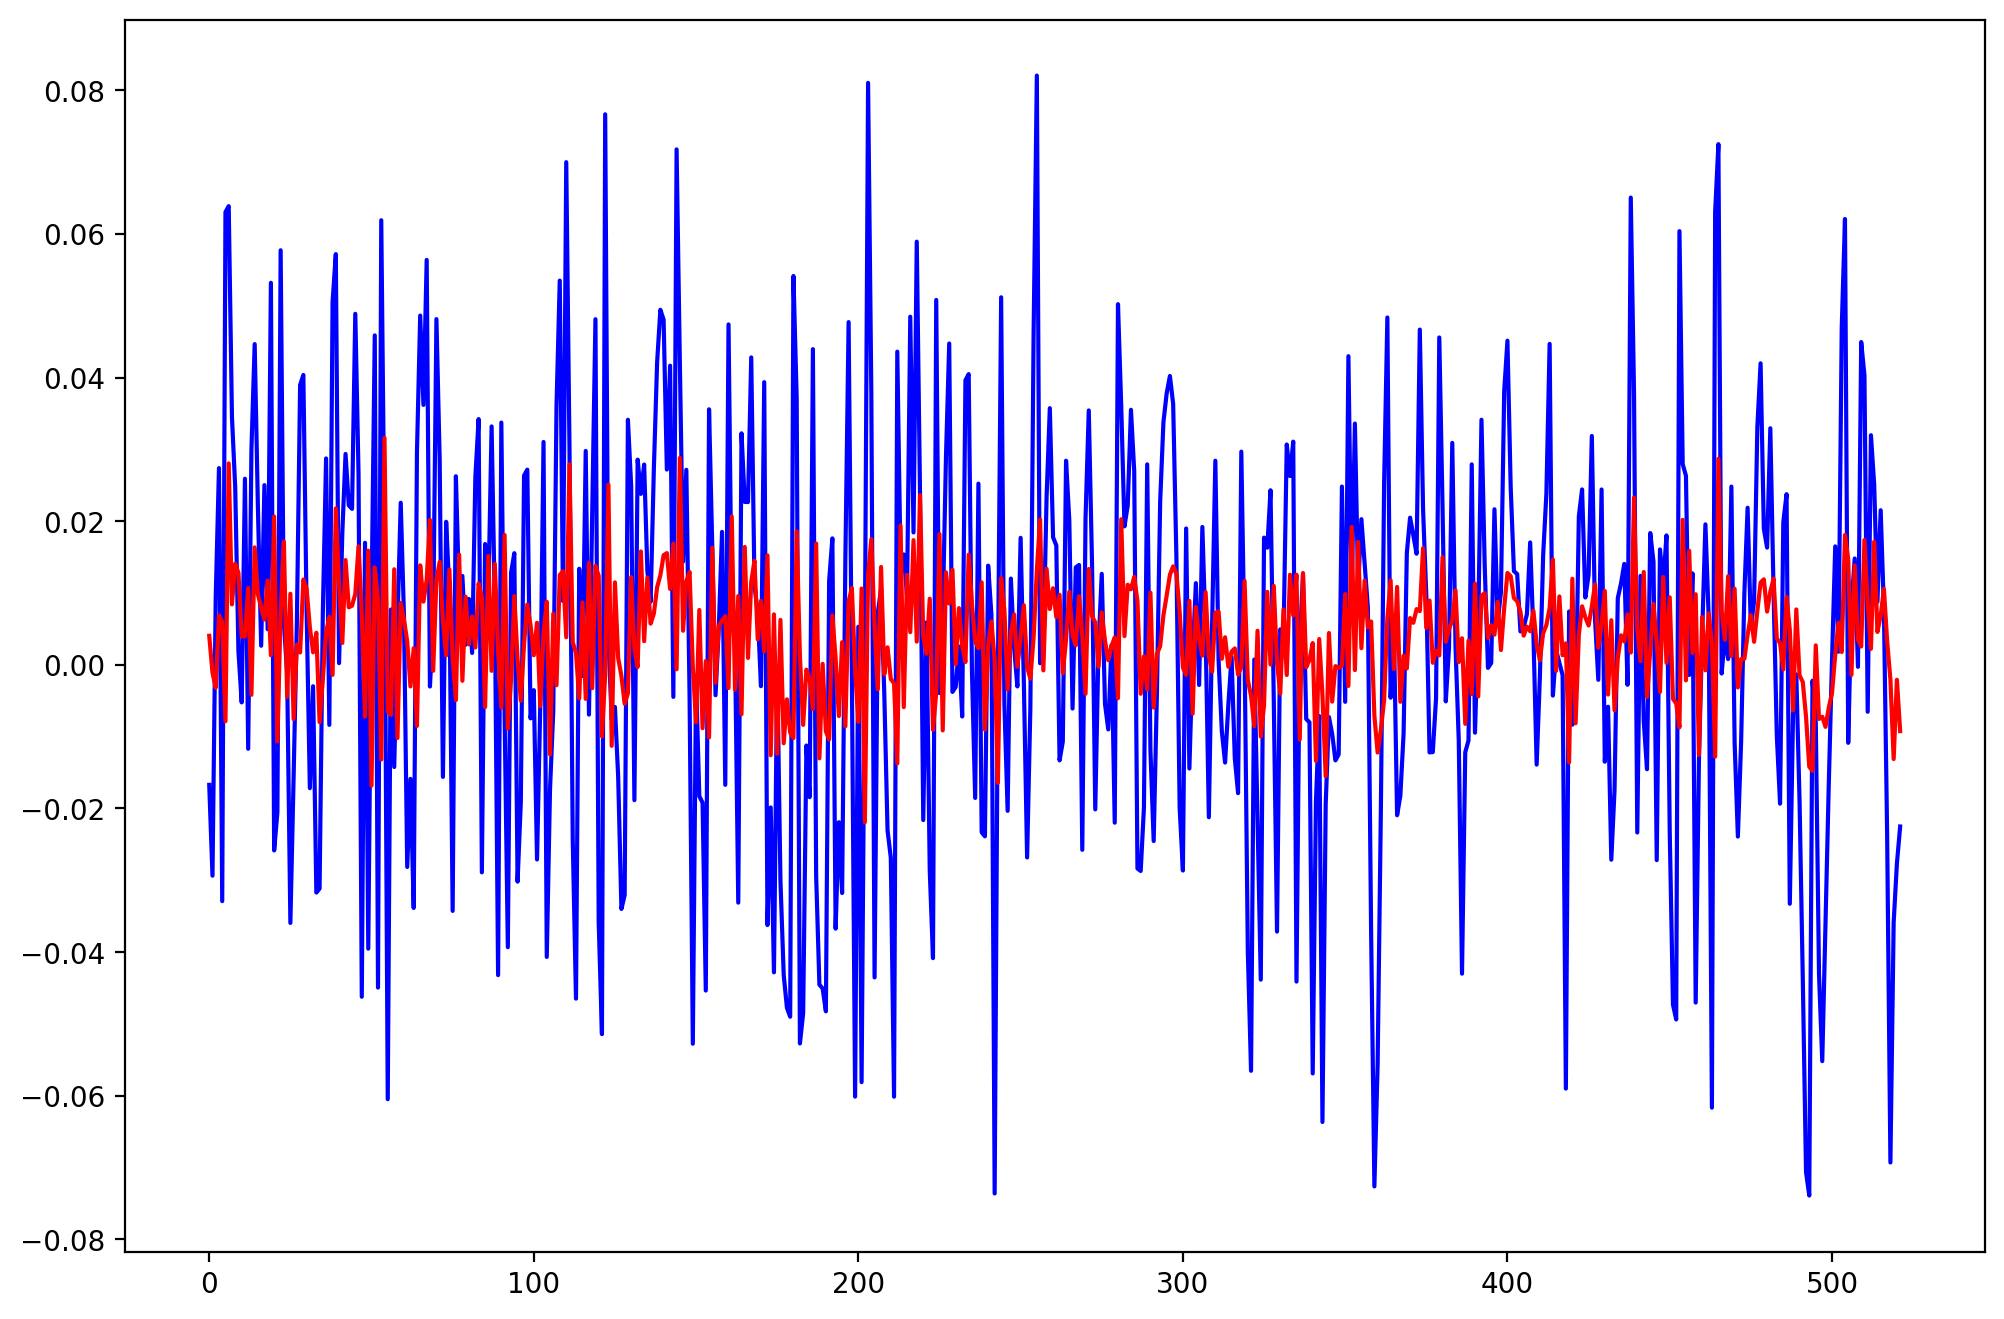

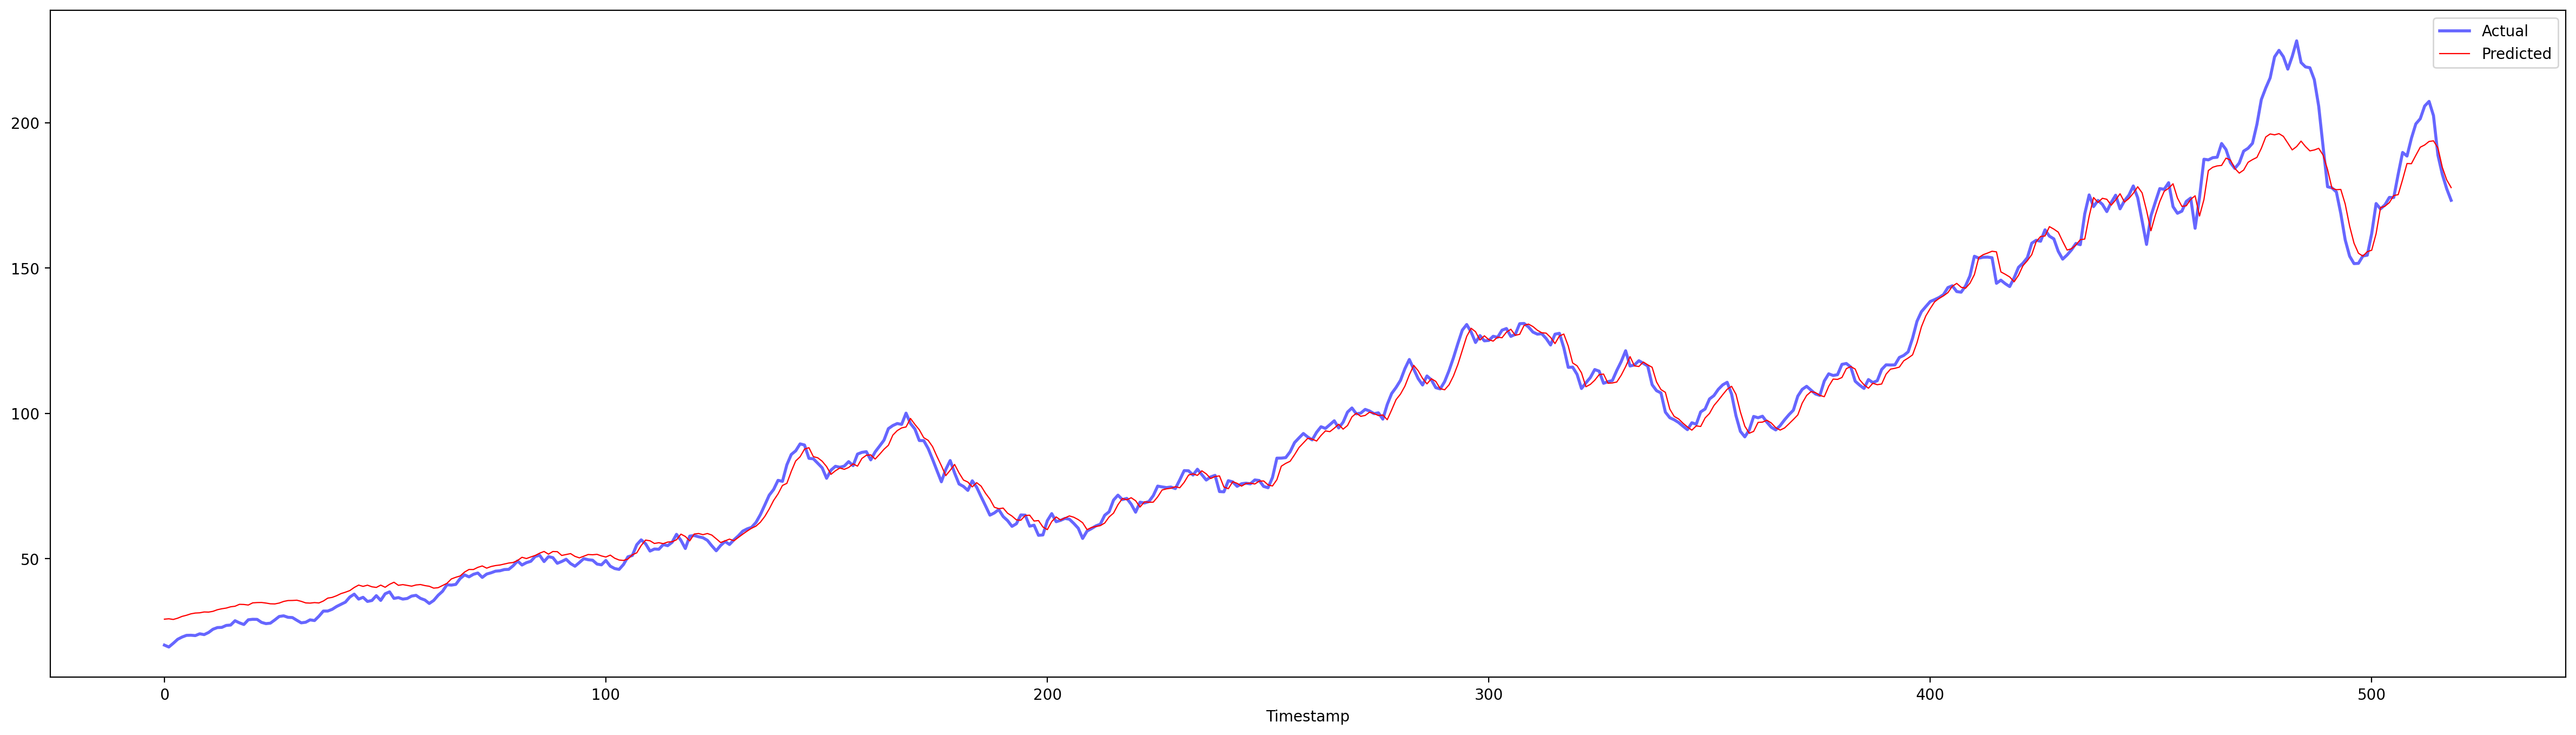